# Import libraries

In [1]:
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset
from torchvision import datasets, transforms, models, ops
from tqdm import tqdm
import pickle

# Prepare MobileNet model for training

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(0))

NVIDIA GeForce RTX 3050 Laptop GPU


In [3]:
BATCH_SIZE = 16  # Optimal batch size after running different batch sizes
NUM_OF_WORKERS = 2
NUM_OF_EPOCHS = 40
NAME_OF_MODEL = "mobile_v3_small"
EARLY_STOPPING_PATIENCE = 15

desired_size = 224
transform = transforms.Compose([transforms.Resize(desired_size),
                                transforms.Pad(padding=(desired_size - 224) // 2),
                                torchvision.transforms.Grayscale(num_output_channels=3),
                                transforms.ToTensor()])

trainset = datasets.FashionMNIST('data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_OF_WORKERS)
testset = datasets.FashionMNIST('data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_OF_WORKERS)

In [4]:
trainloader.dataset.data.shape

torch.Size([60000, 28, 28])

In [5]:
testloader.dataset.data.shape

torch.Size([10000, 28, 28])

In [6]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

Feature batch shape: torch.Size([16, 3, 224, 224])
Labels batch shape: torch.Size([16])


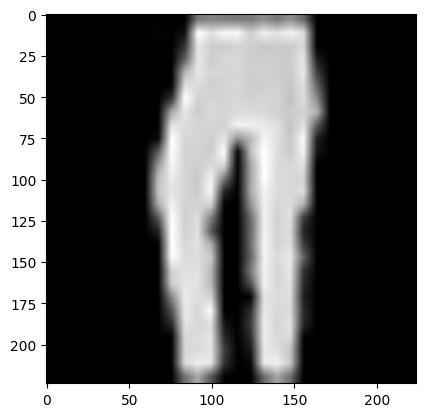

Label: 1


In [7]:
#nex iter gets next 100 images
train_features, train_labels = next(iter(trainloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[7][0].squeeze()
label = train_labels[7]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [8]:
# all_models = models.list_models()
m1 = torchvision.models.get_model("mobilenet_v3_small", num_classes=10, num_channels=1)
# Move your model to the GPU if available
m1.to(device)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [12]:
batch1, label1 = next(iter(trainloader))

Freeze only FC layer

In [14]:
# Freeze all layers
for param in m1.parameters():
    param.requires_grad = False

# Unfreeze last layer
for param in m1.classifier.parameters():
    param.requires_grad = True

## Find out optimal batch size

In [16]:
batch_sizes = [8, 16, 32, 64, 128]

from training_and_evaluate import train_and_eval

batch_tr_info, batch_te_info = train_and_eval(model=m1, trainset=trainset, testset=testset, batch_sizes=batch_sizes,
                                              NAME_OF_MODEL=NAME_OF_MODEL, folder_to_save_in="unfreeze_FC_layer",
                                              NUM_OF_EPOCHS=NUM_OF_EPOCHS,
                                              early_stopping_patience=EARLY_STOPPING_PATIENCE, NUM_OF_WORKERS=NUM_OF_WORKERS)

Epoch 1 Training...


100%|██████████| 7500/7500 [01:48<00:00, 69.16it/s]


Epoch 1 Testing...


100%|██████████| 1250/1250 [00:21<00:00, 58.69it/s]


Epoch 1: Train_accuracy: 31.23%, Train_loss: 1.886594, Test_accuracy: 38.61%, Test_loss: 1.660317
Epoch 2 Training...


100%|██████████| 7500/7500 [02:11<00:00, 57.09it/s]


Epoch 2 Testing...


100%|██████████| 1250/1250 [00:17<00:00, 71.51it/s] 


Epoch 2: Train_accuracy: 40.54%, Train_loss: 1.614865, Test_accuracy: 47.66%, Test_loss: 1.454984
Epoch 3 Training...


100%|██████████| 7500/7500 [01:46<00:00, 70.15it/s]


Epoch 3 Testing...


100%|██████████| 1250/1250 [00:19<00:00, 64.02it/s]


Epoch 3: Train_accuracy: 43.63%, Train_loss: 1.531403, Test_accuracy: 48.79%, Test_loss: 1.372404
Epoch 4 Training...


100%|██████████| 7500/7500 [01:57<00:00, 63.91it/s]


Epoch 4 Testing...


100%|██████████| 1250/1250 [00:19<00:00, 63.31it/s]


Epoch 4: Train_accuracy: 45.42%, Train_loss: 1.480120, Test_accuracy: 50.56%, Test_loss: 1.348028
Epoch 5 Training...


100%|██████████| 7500/7500 [01:45<00:00, 71.39it/s]


Epoch 5 Testing...


100%|██████████| 1250/1250 [00:15<00:00, 79.36it/s] 


Epoch 5: Train_accuracy: 46.52%, Train_loss: 1.450090, Test_accuracy: 51.21%, Test_loss: 1.335630
Epoch 6 Training...


100%|██████████| 7500/7500 [01:43<00:00, 72.60it/s]


Epoch 6 Testing...


100%|██████████| 1250/1250 [00:15<00:00, 79.84it/s] 


Epoch 6: Train_accuracy: 46.97%, Train_loss: 1.428652, Test_accuracy: 50.66%, Test_loss: 1.380519
Epoch 7 Training...


100%|██████████| 7500/7500 [01:40<00:00, 74.30it/s]


Epoch 7 Testing...


100%|██████████| 1250/1250 [00:17<00:00, 70.39it/s]


Epoch 7: Train_accuracy: 47.51%, Train_loss: 1.411913, Test_accuracy: 52.71%, Test_loss: 1.277501
Epoch 8 Training...


100%|██████████| 7500/7500 [02:09<00:00, 57.89it/s]


Epoch 8 Testing...


100%|██████████| 1250/1250 [00:20<00:00, 62.46it/s]


Epoch 8: Train_accuracy: 48.32%, Train_loss: 1.393069, Test_accuracy: 52.03%, Test_loss: 1.316230
Epoch 9 Training...


100%|██████████| 7500/7500 [02:18<00:00, 54.09it/s]


Epoch 9 Testing...


100%|██████████| 1250/1250 [00:15<00:00, 78.32it/s] 


Epoch 9: Train_accuracy: 48.41%, Train_loss: 1.382686, Test_accuracy: 54.15%, Test_loss: 1.246898
Epoch 10 Training...


100%|██████████| 7500/7500 [01:55<00:00, 65.18it/s]


Epoch 10 Testing...


100%|██████████| 1250/1250 [00:17<00:00, 70.31it/s]


Epoch 10: Train_accuracy: 48.95%, Train_loss: 1.372228, Test_accuracy: 51.62%, Test_loss: 1.308911
Epoch 11 Training...


100%|██████████| 7500/7500 [02:08<00:00, 58.48it/s]


Epoch 11 Testing...


100%|██████████| 1250/1250 [00:17<00:00, 73.38it/s]


Epoch 11: Train_accuracy: 49.11%, Train_loss: 1.366242, Test_accuracy: 55.47%, Test_loss: 1.215996
Epoch 12 Training...


100%|██████████| 7500/7500 [01:44<00:00, 71.85it/s]


Epoch 12 Testing...


100%|██████████| 1250/1250 [00:18<00:00, 67.78it/s] 


Epoch 12: Train_accuracy: 49.94%, Train_loss: 1.354090, Test_accuracy: 52.21%, Test_loss: 1.265068
Epoch 13 Training...


100%|██████████| 7500/7500 [01:55<00:00, 64.83it/s]


Epoch 13 Testing...


100%|██████████| 1250/1250 [00:22<00:00, 55.54it/s]


Epoch 13: Train_accuracy: 49.88%, Train_loss: 1.347806, Test_accuracy: 55.40%, Test_loss: 1.203195
Epoch 14 Training...


100%|██████████| 7500/7500 [01:52<00:00, 66.64it/s]


Epoch 14 Testing...


100%|██████████| 1250/1250 [00:18<00:00, 68.54it/s]


Epoch 14: Train_accuracy: 49.95%, Train_loss: 1.339957, Test_accuracy: 54.50%, Test_loss: 1.231205
Epoch 15 Training...


100%|██████████| 7500/7500 [02:01<00:00, 61.76it/s]


Epoch 15 Testing...


100%|██████████| 1250/1250 [00:19<00:00, 64.51it/s]


Epoch 15: Train_accuracy: 50.15%, Train_loss: 1.340915, Test_accuracy: 52.78%, Test_loss: 1.293357
Epoch 16 Training...


100%|██████████| 7500/7500 [02:00<00:00, 62.27it/s]


Epoch 16 Testing...


100%|██████████| 1250/1250 [00:18<00:00, 69.21it/s]


Epoch 16: Train_accuracy: 50.18%, Train_loss: 1.334072, Test_accuracy: 55.25%, Test_loss: 1.211724
Epoch 17 Training...


100%|██████████| 7500/7500 [02:03<00:00, 60.88it/s]


Epoch 17 Testing...


100%|██████████| 1250/1250 [00:18<00:00, 68.21it/s]


Epoch 17: Train_accuracy: 50.43%, Train_loss: 1.331700, Test_accuracy: 56.00%, Test_loss: 1.204374
Epoch 18 Training...


100%|██████████| 7500/7500 [01:59<00:00, 62.83it/s]


Epoch 18 Testing...


100%|██████████| 1250/1250 [00:18<00:00, 67.36it/s]


Epoch 18: Train_accuracy: 50.86%, Train_loss: 1.318983, Test_accuracy: 56.64%, Test_loss: 1.172664
Epoch 19 Training...


100%|██████████| 7500/7500 [01:59<00:00, 62.66it/s]


Epoch 19 Testing...


100%|██████████| 1250/1250 [00:18<00:00, 66.12it/s]


Epoch 19: Train_accuracy: 50.91%, Train_loss: 1.319421, Test_accuracy: 57.78%, Test_loss: 1.150327
Epoch 20 Training...


100%|██████████| 7500/7500 [02:10<00:00, 57.31it/s]


Epoch 20 Testing...


100%|██████████| 1250/1250 [00:18<00:00, 68.41it/s]


Epoch 20: Train_accuracy: 51.13%, Train_loss: 1.312223, Test_accuracy: 57.36%, Test_loss: 1.154176
Epoch 21 Training...


100%|██████████| 7500/7500 [02:03<00:00, 60.63it/s]


Epoch 21 Testing...


100%|██████████| 1250/1250 [00:19<00:00, 65.28it/s]


Epoch 21: Train_accuracy: 51.50%, Train_loss: 1.307761, Test_accuracy: 54.83%, Test_loss: 1.232517
Epoch 22 Training...


100%|██████████| 7500/7500 [01:55<00:00, 64.83it/s]


Epoch 22 Testing...


100%|██████████| 1250/1250 [00:17<00:00, 70.60it/s]


Epoch 22: Train_accuracy: 51.10%, Train_loss: 1.308787, Test_accuracy: 53.52%, Test_loss: 1.217054
Epoch 23 Training...


100%|██████████| 7500/7500 [01:46<00:00, 70.60it/s]


Epoch 23 Testing...


100%|██████████| 1250/1250 [00:18<00:00, 66.75it/s]


Epoch 23: Train_accuracy: 51.39%, Train_loss: 1.301776, Test_accuracy: 56.41%, Test_loss: 1.159752
Epoch 24 Training...


100%|██████████| 7500/7500 [01:52<00:00, 66.91it/s]


Epoch 24 Testing...


100%|██████████| 1250/1250 [00:16<00:00, 74.47it/s] 


Epoch 24: Train_accuracy: 51.55%, Train_loss: 1.296344, Test_accuracy: 55.47%, Test_loss: 1.192570
Epoch 25 Training...


100%|██████████| 7500/7500 [01:45<00:00, 70.86it/s]


Epoch 25 Testing...


100%|██████████| 1250/1250 [00:18<00:00, 67.04it/s] 


Epoch 25: Train_accuracy: 51.44%, Train_loss: 1.298729, Test_accuracy: 57.59%, Test_loss: 1.174287
Epoch 26 Training...


100%|██████████| 7500/7500 [02:10<00:00, 57.42it/s]


Epoch 26 Testing...


100%|██████████| 1250/1250 [00:21<00:00, 59.17it/s]


Epoch 26: Train_accuracy: 51.84%, Train_loss: 1.288879, Test_accuracy: 56.25%, Test_loss: 1.196953
Epoch 27 Training...


100%|██████████| 7500/7500 [02:09<00:00, 57.89it/s]


Epoch 27 Testing...


100%|██████████| 1250/1250 [00:19<00:00, 62.84it/s]


Epoch 27: Train_accuracy: 51.91%, Train_loss: 1.292012, Test_accuracy: 56.18%, Test_loss: 1.214398
Epoch 28 Training...


100%|██████████| 7500/7500 [01:57<00:00, 63.76it/s]


Epoch 28 Testing...


100%|██████████| 1250/1250 [00:18<00:00, 66.00it/s]


Epoch 28: Train_accuracy: 52.30%, Train_loss: 1.284480, Test_accuracy: 54.57%, Test_loss: 1.220414
Epoch 29 Training...


100%|██████████| 7500/7500 [02:04<00:00, 60.19it/s]


Epoch 29 Testing...


100%|██████████| 1250/1250 [00:19<00:00, 63.85it/s] 


Epoch 29: Train_accuracy: 51.92%, Train_loss: 1.285059, Test_accuracy: 56.95%, Test_loss: 1.156695
Epoch 30 Training...


100%|██████████| 7500/7500 [02:03<00:00, 60.50it/s]


Epoch 30 Testing...


100%|██████████| 1250/1250 [00:16<00:00, 76.71it/s] 


Epoch 30: Train_accuracy: 52.20%, Train_loss: 1.278621, Test_accuracy: 55.57%, Test_loss: 1.202029
Epoch 31 Training...


100%|██████████| 7500/7500 [02:08<00:00, 58.44it/s]


Epoch 31 Testing...


100%|██████████| 1250/1250 [00:23<00:00, 54.22it/s]


Epoch 31: Train_accuracy: 52.12%, Train_loss: 1.281947, Test_accuracy: 57.77%, Test_loss: 1.148565
Epoch 32 Training...


100%|██████████| 7500/7500 [02:18<00:00, 54.03it/s]


Epoch 32 Testing...


100%|██████████| 1250/1250 [00:22<00:00, 55.55it/s]


Epoch 32: Train_accuracy: 52.48%, Train_loss: 1.273648, Test_accuracy: 58.47%, Test_loss: 1.133174
Epoch 33 Training...


100%|██████████| 7500/7500 [02:08<00:00, 58.22it/s]


Epoch 33 Testing...


100%|██████████| 1250/1250 [00:20<00:00, 61.62it/s]


Epoch 33: Train_accuracy: 52.45%, Train_loss: 1.275770, Test_accuracy: 58.36%, Test_loss: 1.125781
Epoch 34 Training...


100%|██████████| 7500/7500 [02:19<00:00, 53.79it/s]


Epoch 34 Testing...


100%|██████████| 1250/1250 [00:20<00:00, 60.37it/s]


Epoch 34: Train_accuracy: 52.35%, Train_loss: 1.272453, Test_accuracy: 54.21%, Test_loss: 1.214427
Epoch 35 Training...


100%|██████████| 7500/7500 [02:04<00:00, 60.40it/s]


Epoch 35 Testing...


100%|██████████| 1250/1250 [00:17<00:00, 71.20it/s]


Epoch 35: Train_accuracy: 52.02%, Train_loss: 1.279510, Test_accuracy: 54.78%, Test_loss: 1.218285
Epoch 36 Training...


100%|██████████| 7500/7500 [02:11<00:00, 57.21it/s]


Epoch 36 Testing...


100%|██████████| 1250/1250 [00:19<00:00, 63.80it/s] 


Epoch 36: Train_accuracy: 52.36%, Train_loss: 1.274160, Test_accuracy: 55.60%, Test_loss: 1.182747
Epoch 37 Training...


100%|██████████| 7500/7500 [02:10<00:00, 57.35it/s]


Epoch 37 Testing...


100%|██████████| 1250/1250 [00:19<00:00, 63.94it/s]


Epoch 37: Train_accuracy: 52.31%, Train_loss: 1.271795, Test_accuracy: 58.67%, Test_loss: 1.127642
Epoch 38 Training...


100%|██████████| 7500/7500 [02:04<00:00, 60.43it/s]


Epoch 38 Testing...


100%|██████████| 1250/1250 [00:24<00:00, 51.03it/s]


Epoch 38: Train_accuracy: 52.50%, Train_loss: 1.270745, Test_accuracy: 55.66%, Test_loss: 1.174469
Epoch 39 Training...


100%|██████████| 7500/7500 [02:04<00:00, 60.39it/s]


Epoch 39 Testing...


100%|██████████| 1250/1250 [00:19<00:00, 64.36it/s]


Epoch 39: Train_accuracy: 52.75%, Train_loss: 1.270709, Test_accuracy: 55.45%, Test_loss: 1.193957
Epoch 40 Training...


100%|██████████| 7500/7500 [02:03<00:00, 60.58it/s]


Epoch 40 Testing...


100%|██████████| 1250/1250 [00:16<00:00, 76.28it/s] 


Epoch 40: Train_accuracy: 52.75%, Train_loss: 1.266763, Test_accuracy: 57.16%, Test_loss: 1.163858
Epoch 1 Training...


100%|██████████| 3750/3750 [01:13<00:00, 51.33it/s]


Epoch 1 Testing...


100%|██████████| 625/625 [00:12<00:00, 48.83it/s]


Epoch 1: Train_accuracy: 33.41%, Train_loss: 1.829043, Test_accuracy: 41.32%, Test_loss: 1.569524
Epoch 2 Training...


100%|██████████| 3750/3750 [01:13<00:00, 50.77it/s]


Epoch 2 Testing...


100%|██████████| 625/625 [00:12<00:00, 50.89it/s]


Epoch 2: Train_accuracy: 43.94%, Train_loss: 1.536780, Test_accuracy: 50.30%, Test_loss: 1.382949
Epoch 3 Training...


100%|██████████| 3750/3750 [01:08<00:00, 54.50it/s]


Epoch 3 Testing...


100%|██████████| 625/625 [00:11<00:00, 54.69it/s]


Epoch 3: Train_accuracy: 46.59%, Train_loss: 1.445183, Test_accuracy: 48.24%, Test_loss: 1.372127
Epoch 4 Training...


100%|██████████| 3750/3750 [01:10<00:00, 53.32it/s]


Epoch 4 Testing...


100%|██████████| 625/625 [00:12<00:00, 48.85it/s]


Epoch 4: Train_accuracy: 48.55%, Train_loss: 1.397922, Test_accuracy: 52.08%, Test_loss: 1.292723
Epoch 5 Training...


100%|██████████| 3750/3750 [01:11<00:00, 52.14it/s]


Epoch 5 Testing...


100%|██████████| 625/625 [00:11<00:00, 53.67it/s]


Epoch 5: Train_accuracy: 49.37%, Train_loss: 1.362445, Test_accuracy: 51.81%, Test_loss: 1.308004
Epoch 6 Training...


100%|██████████| 3750/3750 [01:11<00:00, 52.82it/s]


Epoch 6 Testing...


100%|██████████| 625/625 [00:11<00:00, 52.55it/s]


Epoch 6: Train_accuracy: 50.08%, Train_loss: 1.340072, Test_accuracy: 54.23%, Test_loss: 1.233786
Epoch 7 Training...


100%|██████████| 3750/3750 [01:09<00:00, 54.03it/s]


Epoch 7 Testing...


100%|██████████| 625/625 [00:11<00:00, 54.42it/s]


Epoch 7: Train_accuracy: 51.18%, Train_loss: 1.321146, Test_accuracy: 53.13%, Test_loss: 1.250988
Epoch 8 Training...


100%|██████████| 3750/3750 [01:10<00:00, 53.15it/s]


Epoch 8 Testing...


100%|██████████| 625/625 [00:12<00:00, 50.55it/s]


Epoch 8: Train_accuracy: 51.31%, Train_loss: 1.307170, Test_accuracy: 54.37%, Test_loss: 1.217329
Epoch 9 Training...


100%|██████████| 3750/3750 [01:14<00:00, 50.26it/s]


Epoch 9 Testing...


100%|██████████| 625/625 [00:12<00:00, 51.49it/s]


Epoch 9: Train_accuracy: 51.91%, Train_loss: 1.291304, Test_accuracy: 52.55%, Test_loss: 1.231685
Epoch 10 Training...


100%|██████████| 3750/3750 [01:10<00:00, 53.22it/s]


Epoch 10 Testing...


100%|██████████| 625/625 [00:12<00:00, 48.62it/s]


Epoch 10: Train_accuracy: 51.92%, Train_loss: 1.285400, Test_accuracy: 55.13%, Test_loss: 1.205063
Epoch 11 Training...


100%|██████████| 3750/3750 [01:10<00:00, 53.21it/s]


Epoch 11 Testing...


100%|██████████| 625/625 [00:12<00:00, 48.34it/s]


Epoch 11: Train_accuracy: 52.67%, Train_loss: 1.269465, Test_accuracy: 55.17%, Test_loss: 1.192092
Epoch 12 Training...


100%|██████████| 3750/3750 [01:14<00:00, 50.07it/s]


Epoch 12 Testing...


100%|██████████| 625/625 [00:15<00:00, 41.06it/s]


Epoch 12: Train_accuracy: 53.22%, Train_loss: 1.261449, Test_accuracy: 56.44%, Test_loss: 1.158976
Epoch 13 Training...


100%|██████████| 3750/3750 [01:18<00:00, 47.81it/s]


Epoch 13 Testing...


100%|██████████| 625/625 [00:12<00:00, 49.78it/s]


Epoch 13: Train_accuracy: 53.22%, Train_loss: 1.253924, Test_accuracy: 54.52%, Test_loss: 1.200794
Epoch 14 Training...


100%|██████████| 3750/3750 [01:16<00:00, 49.18it/s]


Epoch 14 Testing...


100%|██████████| 625/625 [00:12<00:00, 48.96it/s]


Epoch 14: Train_accuracy: 53.45%, Train_loss: 1.247963, Test_accuracy: 53.15%, Test_loss: 1.231849
Epoch 15 Training...


100%|██████████| 3750/3750 [01:16<00:00, 49.26it/s]


Epoch 15 Testing...


100%|██████████| 625/625 [00:13<00:00, 48.04it/s]


Epoch 15: Train_accuracy: 53.75%, Train_loss: 1.235846, Test_accuracy: 58.13%, Test_loss: 1.137586
Epoch 16 Training...


100%|██████████| 3750/3750 [01:21<00:00, 46.06it/s]


Epoch 16 Testing...


100%|██████████| 625/625 [00:14<00:00, 42.92it/s]


Epoch 16: Train_accuracy: 54.10%, Train_loss: 1.225945, Test_accuracy: 55.75%, Test_loss: 1.176307
Epoch 17 Training...


100%|██████████| 3750/3750 [01:17<00:00, 48.55it/s]


Epoch 17 Testing...


100%|██████████| 625/625 [00:14<00:00, 44.63it/s]


Epoch 17: Train_accuracy: 54.11%, Train_loss: 1.231114, Test_accuracy: 54.97%, Test_loss: 1.179493
Epoch 18 Training...


100%|██████████| 3750/3750 [01:11<00:00, 52.51it/s]


Epoch 18 Testing...


100%|██████████| 625/625 [00:12<00:00, 49.93it/s]


Epoch 18: Train_accuracy: 54.10%, Train_loss: 1.229919, Test_accuracy: 57.76%, Test_loss: 1.144792
Epoch 19 Training...


100%|██████████| 3750/3750 [01:17<00:00, 48.26it/s]


Epoch 19 Testing...


100%|██████████| 625/625 [00:13<00:00, 47.76it/s]


Epoch 19: Train_accuracy: 54.30%, Train_loss: 1.225184, Test_accuracy: 56.53%, Test_loss: 1.144010
Epoch 20 Training...


100%|██████████| 3750/3750 [01:13<00:00, 51.21it/s]


Epoch 20 Testing...


100%|██████████| 625/625 [00:12<00:00, 51.77it/s]


Epoch 20: Train_accuracy: 54.37%, Train_loss: 1.222331, Test_accuracy: 57.10%, Test_loss: 1.145800
Epoch 21 Training...


100%|██████████| 3750/3750 [01:09<00:00, 53.92it/s]


Epoch 21 Testing...


100%|██████████| 625/625 [00:12<00:00, 49.71it/s]


Epoch 21: Train_accuracy: 54.66%, Train_loss: 1.213908, Test_accuracy: 58.22%, Test_loss: 1.124231
Epoch 22 Training...


100%|██████████| 3750/3750 [01:09<00:00, 54.18it/s]


Epoch 22 Testing...


100%|██████████| 625/625 [00:11<00:00, 53.59it/s]


Epoch 22: Train_accuracy: 54.78%, Train_loss: 1.210158, Test_accuracy: 59.32%, Test_loss: 1.102689
Epoch 23 Training...


100%|██████████| 3750/3750 [01:06<00:00, 55.98it/s]


Epoch 23 Testing...


100%|██████████| 625/625 [00:14<00:00, 42.73it/s]


Epoch 23: Train_accuracy: 54.80%, Train_loss: 1.208306, Test_accuracy: 59.12%, Test_loss: 1.098350
Epoch 24 Training...


100%|██████████| 3750/3750 [01:15<00:00, 49.38it/s]


Epoch 24 Testing...


100%|██████████| 625/625 [00:13<00:00, 45.09it/s]


Epoch 24: Train_accuracy: 54.83%, Train_loss: 1.202519, Test_accuracy: 58.20%, Test_loss: 1.114917
Epoch 25 Training...


100%|██████████| 3750/3750 [01:18<00:00, 47.50it/s]


Epoch 25 Testing...


100%|██████████| 625/625 [00:13<00:00, 46.90it/s]


Epoch 25: Train_accuracy: 54.87%, Train_loss: 1.201602, Test_accuracy: 58.56%, Test_loss: 1.107787
Epoch 26 Training...


100%|██████████| 3750/3750 [01:23<00:00, 44.86it/s]


Epoch 26 Testing...


100%|██████████| 625/625 [00:15<00:00, 41.32it/s]


Epoch 26: Train_accuracy: 55.36%, Train_loss: 1.195194, Test_accuracy: 57.61%, Test_loss: 1.110093
Epoch 27 Training...


100%|██████████| 3750/3750 [01:19<00:00, 47.32it/s]


Epoch 27 Testing...


100%|██████████| 625/625 [00:13<00:00, 45.12it/s]


Epoch 27: Train_accuracy: 55.24%, Train_loss: 1.197948, Test_accuracy: 58.84%, Test_loss: 1.109928
Epoch 28 Training...


100%|██████████| 3750/3750 [01:17<00:00, 48.18it/s]


Epoch 28 Testing...


100%|██████████| 625/625 [00:15<00:00, 40.25it/s]


Epoch 28: Train_accuracy: 55.55%, Train_loss: 1.188253, Test_accuracy: 57.47%, Test_loss: 1.136338
Epoch 29 Training...


100%|██████████| 3750/3750 [01:23<00:00, 44.73it/s]


Epoch 29 Testing...


100%|██████████| 625/625 [00:13<00:00, 45.79it/s]


Epoch 29: Train_accuracy: 55.41%, Train_loss: 1.191473, Test_accuracy: 58.67%, Test_loss: 1.121262
Epoch 30 Training...


100%|██████████| 3750/3750 [01:12<00:00, 51.47it/s]


Epoch 30 Testing...


100%|██████████| 625/625 [00:13<00:00, 45.86it/s]


Epoch 30: Train_accuracy: 55.65%, Train_loss: 1.186947, Test_accuracy: 56.61%, Test_loss: 1.135836
Epoch 31 Training...


100%|██████████| 3750/3750 [01:19<00:00, 47.40it/s]


Epoch 31 Testing...


100%|██████████| 625/625 [00:14<00:00, 42.84it/s]


Epoch 31: Train_accuracy: 55.57%, Train_loss: 1.183719, Test_accuracy: 55.46%, Test_loss: 1.166891
Epoch 32 Training...


100%|██████████| 3750/3750 [01:17<00:00, 48.38it/s]


Epoch 32 Testing...


100%|██████████| 625/625 [00:12<00:00, 48.35it/s]


Epoch 32: Train_accuracy: 55.85%, Train_loss: 1.179477, Test_accuracy: 54.89%, Test_loss: 1.183467
Epoch 33 Training...


100%|██████████| 3750/3750 [01:11<00:00, 52.38it/s]


Epoch 33 Testing...


100%|██████████| 625/625 [00:12<00:00, 50.18it/s]


Epoch 33: Train_accuracy: 55.73%, Train_loss: 1.180320, Test_accuracy: 56.94%, Test_loss: 1.143761
Epoch 34 Training...


100%|██████████| 3750/3750 [01:15<00:00, 49.92it/s]


Epoch 34 Testing...


100%|██████████| 625/625 [00:14<00:00, 43.29it/s]


Epoch 34: Train_accuracy: 55.96%, Train_loss: 1.176228, Test_accuracy: 57.68%, Test_loss: 1.130830
Epoch 35 Training...


100%|██████████| 3750/3750 [01:24<00:00, 44.16it/s]


Epoch 35 Testing...


100%|██████████| 625/625 [00:16<00:00, 38.20it/s]


Epoch 35: Train_accuracy: 55.92%, Train_loss: 1.175765, Test_accuracy: 58.80%, Test_loss: 1.122148
Epoch 36 Training...


100%|██████████| 3750/3750 [01:14<00:00, 50.21it/s]


Epoch 36 Testing...


100%|██████████| 625/625 [00:13<00:00, 47.01it/s]


Epoch 36: Train_accuracy: 55.78%, Train_loss: 1.177957, Test_accuracy: 58.89%, Test_loss: 1.090070
Epoch 37 Training...


100%|██████████| 3750/3750 [01:24<00:00, 44.30it/s]


Epoch 37 Testing...


100%|██████████| 625/625 [00:17<00:00, 36.58it/s]


Epoch 37: Train_accuracy: 55.91%, Train_loss: 1.171411, Test_accuracy: 60.44%, Test_loss: 1.062281
Epoch 38 Training...


100%|██████████| 3750/3750 [01:17<00:00, 48.14it/s]


Epoch 38 Testing...


100%|██████████| 625/625 [00:12<00:00, 48.18it/s]


Epoch 38: Train_accuracy: 56.23%, Train_loss: 1.171880, Test_accuracy: 58.80%, Test_loss: 1.088875
Epoch 39 Training...


100%|██████████| 3750/3750 [01:14<00:00, 50.11it/s]


Epoch 39 Testing...


100%|██████████| 625/625 [00:12<00:00, 48.88it/s]


Epoch 39: Train_accuracy: 55.95%, Train_loss: 1.172530, Test_accuracy: 58.94%, Test_loss: 1.088543
Epoch 40 Training...


100%|██████████| 3750/3750 [01:14<00:00, 50.19it/s]


Epoch 40 Testing...


100%|██████████| 625/625 [00:12<00:00, 50.23it/s]


Epoch 40: Train_accuracy: 56.23%, Train_loss: 1.170344, Test_accuracy: 60.59%, Test_loss: 1.061134
Epoch 1 Training...


100%|██████████| 1875/1875 [00:50<00:00, 37.41it/s]


Epoch 1 Testing...


100%|██████████| 313/313 [00:10<00:00, 31.04it/s]


Epoch 1: Train_accuracy: 30.75%, Train_loss: 1.942007, Test_accuracy: 37.57%, Test_loss: 1.719172
Epoch 2 Training...


100%|██████████| 1875/1875 [00:53<00:00, 35.16it/s]


Epoch 2 Testing...


100%|██████████| 313/313 [00:11<00:00, 27.80it/s]


Epoch 2: Train_accuracy: 41.19%, Train_loss: 1.644223, Test_accuracy: 44.82%, Test_loss: 1.548232
Epoch 3 Training...


100%|██████████| 1875/1875 [00:51<00:00, 36.45it/s]


Epoch 3 Testing...


100%|██████████| 313/313 [00:10<00:00, 30.54it/s]


Epoch 3: Train_accuracy: 44.41%, Train_loss: 1.535624, Test_accuracy: 48.81%, Test_loss: 1.455367
Epoch 4 Training...


100%|██████████| 1875/1875 [00:54<00:00, 34.66it/s]


Epoch 4 Testing...


100%|██████████| 313/313 [00:11<00:00, 28.29it/s]


Epoch 4: Train_accuracy: 46.42%, Train_loss: 1.467074, Test_accuracy: 48.36%, Test_loss: 1.422069
Epoch 5 Training...


100%|██████████| 1875/1875 [00:57<00:00, 32.74it/s]


Epoch 5 Testing...


100%|██████████| 313/313 [00:10<00:00, 28.57it/s]


Epoch 5: Train_accuracy: 47.22%, Train_loss: 1.430353, Test_accuracy: 50.64%, Test_loss: 1.369529
Epoch 6 Training...


100%|██████████| 1875/1875 [00:56<00:00, 33.42it/s]


Epoch 6 Testing...


100%|██████████| 313/313 [00:10<00:00, 29.56it/s]


Epoch 6: Train_accuracy: 48.23%, Train_loss: 1.397914, Test_accuracy: 51.11%, Test_loss: 1.350139
Epoch 7 Training...


100%|██████████| 1875/1875 [00:55<00:00, 33.61it/s]


Epoch 7 Testing...


100%|██████████| 313/313 [00:10<00:00, 29.15it/s]


Epoch 7: Train_accuracy: 49.08%, Train_loss: 1.376222, Test_accuracy: 50.80%, Test_loss: 1.332051
Epoch 8 Training...


100%|██████████| 1875/1875 [00:54<00:00, 34.46it/s]


Epoch 8 Testing...


100%|██████████| 313/313 [00:10<00:00, 28.59it/s]


Epoch 8: Train_accuracy: 49.72%, Train_loss: 1.358730, Test_accuracy: 47.97%, Test_loss: 1.370138
Epoch 9 Training...


100%|██████████| 1875/1875 [00:56<00:00, 32.90it/s]


Epoch 9 Testing...


100%|██████████| 313/313 [00:10<00:00, 31.21it/s]


Epoch 9: Train_accuracy: 50.15%, Train_loss: 1.340105, Test_accuracy: 52.27%, Test_loss: 1.305816
Epoch 10 Training...


100%|██████████| 1875/1875 [00:55<00:00, 33.71it/s]


Epoch 10 Testing...


100%|██████████| 313/313 [00:11<00:00, 27.75it/s]


Epoch 10: Train_accuracy: 50.39%, Train_loss: 1.328595, Test_accuracy: 52.84%, Test_loss: 1.270216
Epoch 11 Training...


100%|██████████| 1875/1875 [00:56<00:00, 33.47it/s]


Epoch 11 Testing...


100%|██████████| 313/313 [00:11<00:00, 28.01it/s]


Epoch 11: Train_accuracy: 50.91%, Train_loss: 1.315231, Test_accuracy: 52.84%, Test_loss: 1.278919
Epoch 12 Training...


100%|██████████| 1875/1875 [00:56<00:00, 33.01it/s]


Epoch 12 Testing...


100%|██████████| 313/313 [00:10<00:00, 28.72it/s]


Epoch 12: Train_accuracy: 51.20%, Train_loss: 1.309786, Test_accuracy: 53.75%, Test_loss: 1.265261
Epoch 13 Training...


100%|██████████| 1875/1875 [00:52<00:00, 35.86it/s]


Epoch 13 Testing...


100%|██████████| 313/313 [00:11<00:00, 27.19it/s]


Epoch 13: Train_accuracy: 51.54%, Train_loss: 1.299316, Test_accuracy: 53.70%, Test_loss: 1.258996
Epoch 14 Training...


100%|██████████| 1875/1875 [00:52<00:00, 35.50it/s]


Epoch 14 Testing...


100%|██████████| 313/313 [00:10<00:00, 30.19it/s]


Epoch 14: Train_accuracy: 51.99%, Train_loss: 1.288943, Test_accuracy: 53.46%, Test_loss: 1.256670
Epoch 15 Training...


100%|██████████| 1875/1875 [00:54<00:00, 34.62it/s]


Epoch 15 Testing...


100%|██████████| 313/313 [00:11<00:00, 27.34it/s]


Epoch 15: Train_accuracy: 52.07%, Train_loss: 1.279362, Test_accuracy: 54.36%, Test_loss: 1.228062
Epoch 16 Training...


100%|██████████| 1875/1875 [00:53<00:00, 35.16it/s]


Epoch 16 Testing...


100%|██████████| 313/313 [00:10<00:00, 31.12it/s]


Epoch 16: Train_accuracy: 52.65%, Train_loss: 1.271472, Test_accuracy: 53.78%, Test_loss: 1.249069
Epoch 17 Training...


100%|██████████| 1875/1875 [00:56<00:00, 33.42it/s]


Epoch 17 Testing...


100%|██████████| 313/313 [00:12<00:00, 25.49it/s]


Epoch 17: Train_accuracy: 52.35%, Train_loss: 1.270835, Test_accuracy: 53.77%, Test_loss: 1.231005
Epoch 18 Training...


100%|██████████| 1875/1875 [00:48<00:00, 38.94it/s]


Epoch 18 Testing...


100%|██████████| 313/313 [00:09<00:00, 32.42it/s]


Epoch 18: Train_accuracy: 52.46%, Train_loss: 1.266869, Test_accuracy: 54.56%, Test_loss: 1.217491
Epoch 19 Training...


100%|██████████| 1875/1875 [00:48<00:00, 38.60it/s]


Epoch 19 Testing...


100%|██████████| 313/313 [00:09<00:00, 31.40it/s]


Epoch 19: Train_accuracy: 52.84%, Train_loss: 1.259894, Test_accuracy: 53.13%, Test_loss: 1.265668
Epoch 20 Training...


100%|██████████| 1875/1875 [00:48<00:00, 38.60it/s]


Epoch 20 Testing...


100%|██████████| 313/313 [00:10<00:00, 31.28it/s]


Epoch 20: Train_accuracy: 52.95%, Train_loss: 1.253260, Test_accuracy: 51.58%, Test_loss: 1.279679
Epoch 21 Training...


100%|██████████| 1875/1875 [00:51<00:00, 36.45it/s]


Epoch 21 Testing...


100%|██████████| 313/313 [00:10<00:00, 30.39it/s]


Epoch 21: Train_accuracy: 52.79%, Train_loss: 1.255251, Test_accuracy: 56.35%, Test_loss: 1.194587
Epoch 22 Training...


100%|██████████| 1875/1875 [00:51<00:00, 36.53it/s]


Epoch 22 Testing...


100%|██████████| 313/313 [00:10<00:00, 30.20it/s]


Epoch 22: Train_accuracy: 53.25%, Train_loss: 1.246759, Test_accuracy: 56.26%, Test_loss: 1.195492
Epoch 23 Training...


100%|██████████| 1875/1875 [00:51<00:00, 36.46it/s]


Epoch 23 Testing...


100%|██████████| 313/313 [00:10<00:00, 30.37it/s]


Epoch 23: Train_accuracy: 53.68%, Train_loss: 1.236948, Test_accuracy: 52.19%, Test_loss: 1.246523
Epoch 24 Training...


100%|██████████| 1875/1875 [00:51<00:00, 36.21it/s]


Epoch 24 Testing...


100%|██████████| 313/313 [00:10<00:00, 29.50it/s]


Epoch 24: Train_accuracy: 53.41%, Train_loss: 1.238765, Test_accuracy: 54.15%, Test_loss: 1.208109
Epoch 25 Training...


100%|██████████| 1875/1875 [00:53<00:00, 35.21it/s]


Epoch 25 Testing...


100%|██████████| 313/313 [00:10<00:00, 30.44it/s]


Epoch 25: Train_accuracy: 53.53%, Train_loss: 1.236673, Test_accuracy: 56.12%, Test_loss: 1.189622
Epoch 26 Training...


100%|██████████| 1875/1875 [00:52<00:00, 35.54it/s]


Epoch 26 Testing...


100%|██████████| 313/313 [00:10<00:00, 29.85it/s]


Epoch 26: Train_accuracy: 53.84%, Train_loss: 1.227734, Test_accuracy: 54.84%, Test_loss: 1.207783
Epoch 27 Training...


100%|██████████| 1875/1875 [00:54<00:00, 34.40it/s]


Epoch 27 Testing...


100%|██████████| 313/313 [00:10<00:00, 29.74it/s]


Epoch 27: Train_accuracy: 53.90%, Train_loss: 1.225642, Test_accuracy: 55.48%, Test_loss: 1.199876
Epoch 28 Training...


100%|██████████| 1875/1875 [00:55<00:00, 33.61it/s]


Epoch 28 Testing...


100%|██████████| 313/313 [00:12<00:00, 25.56it/s]


Epoch 28: Train_accuracy: 53.74%, Train_loss: 1.232251, Test_accuracy: 54.31%, Test_loss: 1.195890
Epoch 29 Training...


100%|██████████| 1875/1875 [00:53<00:00, 34.93it/s]


Epoch 29 Testing...


100%|██████████| 313/313 [00:10<00:00, 28.76it/s]


Epoch 29: Train_accuracy: 54.31%, Train_loss: 1.218308, Test_accuracy: 56.37%, Test_loss: 1.165783
Epoch 30 Training...


100%|██████████| 1875/1875 [00:55<00:00, 33.97it/s]


Epoch 30 Testing...


100%|██████████| 313/313 [00:10<00:00, 28.69it/s]


Epoch 30: Train_accuracy: 54.38%, Train_loss: 1.214918, Test_accuracy: 53.32%, Test_loss: 1.223892
Epoch 31 Training...


100%|██████████| 1875/1875 [00:54<00:00, 34.43it/s]


Epoch 31 Testing...


100%|██████████| 313/313 [00:11<00:00, 27.81it/s]


Epoch 31: Train_accuracy: 54.02%, Train_loss: 1.224386, Test_accuracy: 54.56%, Test_loss: 1.193923
Epoch 32 Training...


100%|██████████| 1875/1875 [00:54<00:00, 34.44it/s]


Epoch 32 Testing...


100%|██████████| 313/313 [00:10<00:00, 28.49it/s]


Epoch 32: Train_accuracy: 54.68%, Train_loss: 1.211316, Test_accuracy: 55.55%, Test_loss: 1.178218
Epoch 33 Training...


100%|██████████| 1875/1875 [00:54<00:00, 34.32it/s]


Epoch 33 Testing...


100%|██████████| 313/313 [00:11<00:00, 28.27it/s]


Epoch 33: Train_accuracy: 54.12%, Train_loss: 1.214028, Test_accuracy: 56.63%, Test_loss: 1.158999
Epoch 34 Training...


100%|██████████| 1875/1875 [00:57<00:00, 32.86it/s]


Epoch 34 Testing...


100%|██████████| 313/313 [00:10<00:00, 29.36it/s]


Epoch 34: Train_accuracy: 54.75%, Train_loss: 1.209943, Test_accuracy: 56.70%, Test_loss: 1.176804
Epoch 35 Training...


100%|██████████| 1875/1875 [00:53<00:00, 35.09it/s]


Epoch 35 Testing...


100%|██████████| 313/313 [00:11<00:00, 27.88it/s]


Epoch 35: Train_accuracy: 54.60%, Train_loss: 1.206989, Test_accuracy: 54.78%, Test_loss: 1.182411
Epoch 36 Training...


100%|██████████| 1875/1875 [00:53<00:00, 35.30it/s]


Epoch 36 Testing...


100%|██████████| 313/313 [00:11<00:00, 28.37it/s]


Epoch 36: Train_accuracy: 54.74%, Train_loss: 1.203015, Test_accuracy: 56.68%, Test_loss: 1.163058
Epoch 37 Training...


100%|██████████| 1875/1875 [00:53<00:00, 35.22it/s]


Epoch 37 Testing...


100%|██████████| 313/313 [00:10<00:00, 29.41it/s]


Epoch 37: Train_accuracy: 54.82%, Train_loss: 1.201718, Test_accuracy: 55.36%, Test_loss: 1.183610
Epoch 38 Training...


100%|██████████| 1875/1875 [00:51<00:00, 36.39it/s]


Epoch 38 Testing...


100%|██████████| 313/313 [00:11<00:00, 28.15it/s]


Epoch 38: Train_accuracy: 55.04%, Train_loss: 1.197536, Test_accuracy: 55.81%, Test_loss: 1.195762
Epoch 39 Training...


100%|██████████| 1875/1875 [00:52<00:00, 35.41it/s]


Epoch 39 Testing...


100%|██████████| 313/313 [00:09<00:00, 33.22it/s]


Epoch 39: Train_accuracy: 54.90%, Train_loss: 1.199593, Test_accuracy: 55.75%, Test_loss: 1.197826
Epoch 40 Training...


100%|██████████| 1875/1875 [00:47<00:00, 39.14it/s]


Epoch 40 Testing...


100%|██████████| 313/313 [00:10<00:00, 30.39it/s]


Epoch 40: Train_accuracy: 55.15%, Train_loss: 1.193897, Test_accuracy: 53.30%, Test_loss: 1.199074
Epoch 1 Training...


100%|██████████| 938/938 [00:50<00:00, 18.46it/s]


Epoch 1 Testing...


100%|██████████| 157/157 [00:13<00:00, 11.25it/s]


Epoch 1: Train_accuracy: 30.72%, Train_loss: 1.985144, Test_accuracy: 41.22%, Test_loss: 1.751440
Epoch 2 Training...


100%|██████████| 938/938 [01:08<00:00, 13.77it/s]


Epoch 2 Testing...


100%|██████████| 157/157 [00:13<00:00, 11.71it/s]


Epoch 2: Train_accuracy: 41.55%, Train_loss: 1.667379, Test_accuracy: 44.75%, Test_loss: 1.566500
Epoch 3 Training...


100%|██████████| 938/938 [00:49<00:00, 18.88it/s]


Epoch 3 Testing...


100%|██████████| 157/157 [00:10<00:00, 14.28it/s]


Epoch 3: Train_accuracy: 44.92%, Train_loss: 1.539367, Test_accuracy: 44.52%, Test_loss: 1.496404
Epoch 4 Training...


100%|██████████| 938/938 [00:48<00:00, 19.35it/s]


Epoch 4 Testing...


100%|██████████| 157/157 [00:10<00:00, 14.66it/s]


Epoch 4: Train_accuracy: 46.77%, Train_loss: 1.467239, Test_accuracy: 47.92%, Test_loss: 1.424356
Epoch 5 Training...


100%|██████████| 938/938 [00:50<00:00, 18.71it/s]


Epoch 5 Testing...


100%|██████████| 157/157 [00:10<00:00, 15.12it/s]


Epoch 5: Train_accuracy: 47.88%, Train_loss: 1.419296, Test_accuracy: 51.33%, Test_loss: 1.364831
Epoch 6 Training...


100%|██████████| 938/938 [00:46<00:00, 20.04it/s]


Epoch 6 Testing...


100%|██████████| 157/157 [00:10<00:00, 15.08it/s]


Epoch 6: Train_accuracy: 49.04%, Train_loss: 1.381005, Test_accuracy: 48.00%, Test_loss: 1.367618
Epoch 7 Training...


100%|██████████| 938/938 [00:47<00:00, 19.70it/s]


Epoch 7 Testing...


100%|██████████| 157/157 [00:10<00:00, 14.67it/s]


Epoch 7: Train_accuracy: 49.50%, Train_loss: 1.356200, Test_accuracy: 51.55%, Test_loss: 1.333661
Epoch 8 Training...


100%|██████████| 938/938 [00:47<00:00, 19.70it/s]


Epoch 8 Testing...


100%|██████████| 157/157 [00:11<00:00, 14.12it/s]


Epoch 8: Train_accuracy: 50.20%, Train_loss: 1.337448, Test_accuracy: 49.33%, Test_loss: 1.336590
Epoch 9 Training...


100%|██████████| 938/938 [00:47<00:00, 19.56it/s]


Epoch 9 Testing...


100%|██████████| 157/157 [00:11<00:00, 14.17it/s]


Epoch 9: Train_accuracy: 50.86%, Train_loss: 1.320246, Test_accuracy: 49.34%, Test_loss: 1.318167
Epoch 10 Training...


100%|██████████| 938/938 [00:48<00:00, 19.46it/s]


Epoch 10 Testing...


100%|██████████| 157/157 [00:10<00:00, 15.39it/s]


Epoch 10: Train_accuracy: 50.93%, Train_loss: 1.307807, Test_accuracy: 52.26%, Test_loss: 1.273578
Epoch 11 Training...


100%|██████████| 938/938 [00:47<00:00, 19.66it/s]


Epoch 11 Testing...


100%|██████████| 157/157 [00:10<00:00, 15.27it/s]


Epoch 11: Train_accuracy: 51.45%, Train_loss: 1.293177, Test_accuracy: 52.20%, Test_loss: 1.281506
Epoch 12 Training...


100%|██████████| 938/938 [00:46<00:00, 19.99it/s]


Epoch 12 Testing...


100%|██████████| 157/157 [00:10<00:00, 14.59it/s]


Epoch 12: Train_accuracy: 51.23%, Train_loss: 1.288075, Test_accuracy: 50.70%, Test_loss: 1.299150
Epoch 13 Training...


100%|██████████| 938/938 [00:48<00:00, 19.53it/s]


Epoch 13 Testing...


100%|██████████| 157/157 [00:11<00:00, 14.07it/s]


Epoch 13: Train_accuracy: 51.95%, Train_loss: 1.274331, Test_accuracy: 53.45%, Test_loss: 1.256655
Epoch 14 Training...


100%|██████████| 938/938 [00:46<00:00, 20.06it/s]


Epoch 14 Testing...


100%|██████████| 157/157 [00:09<00:00, 15.74it/s]


Epoch 14: Train_accuracy: 52.12%, Train_loss: 1.263854, Test_accuracy: 53.14%, Test_loss: 1.245930
Epoch 15 Training...


100%|██████████| 938/938 [00:45<00:00, 20.48it/s]


Epoch 15 Testing...


100%|██████████| 157/157 [00:10<00:00, 14.90it/s]


Epoch 15: Train_accuracy: 52.80%, Train_loss: 1.253495, Test_accuracy: 53.14%, Test_loss: 1.238028
Epoch 16 Training...


100%|██████████| 938/938 [00:46<00:00, 19.96it/s]


Epoch 16 Testing...


100%|██████████| 157/157 [00:10<00:00, 14.86it/s]


Epoch 16: Train_accuracy: 52.79%, Train_loss: 1.248052, Test_accuracy: 53.35%, Test_loss: 1.235600
Epoch 17 Training...


100%|██████████| 938/938 [00:49<00:00, 18.95it/s]


Epoch 17 Testing...


100%|██████████| 157/157 [00:11<00:00, 13.12it/s]


Epoch 17: Train_accuracy: 52.96%, Train_loss: 1.241390, Test_accuracy: 53.31%, Test_loss: 1.225981
Epoch 18 Training...


100%|██████████| 938/938 [00:50<00:00, 18.52it/s]


Epoch 18 Testing...


100%|██████████| 157/157 [00:12<00:00, 12.46it/s]


Epoch 18: Train_accuracy: 53.39%, Train_loss: 1.234307, Test_accuracy: 54.67%, Test_loss: 1.209998
Epoch 19 Training...


100%|██████████| 938/938 [00:49<00:00, 18.84it/s]


Epoch 19 Testing...


100%|██████████| 157/157 [00:10<00:00, 14.88it/s]


Epoch 19: Train_accuracy: 53.43%, Train_loss: 1.230325, Test_accuracy: 53.25%, Test_loss: 1.241306
Epoch 20 Training...


100%|██████████| 938/938 [00:48<00:00, 19.34it/s]


Epoch 20 Testing...


100%|██████████| 157/157 [00:10<00:00, 15.00it/s]


Epoch 20: Train_accuracy: 53.52%, Train_loss: 1.223425, Test_accuracy: 53.51%, Test_loss: 1.216195
Epoch 21 Training...


100%|██████████| 938/938 [00:47<00:00, 19.84it/s]


Epoch 21 Testing...


100%|██████████| 157/157 [00:10<00:00, 15.19it/s]


Epoch 21: Train_accuracy: 53.70%, Train_loss: 1.224218, Test_accuracy: 52.44%, Test_loss: 1.223239
Epoch 22 Training...


100%|██████████| 938/938 [00:46<00:00, 20.18it/s]


Epoch 22 Testing...


100%|██████████| 157/157 [00:10<00:00, 15.00it/s]


Epoch 22: Train_accuracy: 53.78%, Train_loss: 1.217376, Test_accuracy: 54.53%, Test_loss: 1.201766
Epoch 23 Training...


100%|██████████| 938/938 [00:46<00:00, 20.03it/s]


Epoch 23 Testing...


100%|██████████| 157/157 [00:11<00:00, 14.24it/s]


Epoch 23: Train_accuracy: 54.15%, Train_loss: 1.213715, Test_accuracy: 53.22%, Test_loss: 1.224057
Epoch 24 Training...


100%|██████████| 938/938 [00:47<00:00, 19.91it/s]


Epoch 24 Testing...


100%|██████████| 157/157 [00:10<00:00, 14.46it/s]


Epoch 24: Train_accuracy: 54.15%, Train_loss: 1.209080, Test_accuracy: 55.37%, Test_loss: 1.190873
Epoch 25 Training...


100%|██████████| 938/938 [00:48<00:00, 19.39it/s]


Epoch 25 Testing...


100%|██████████| 157/157 [00:10<00:00, 15.56it/s]


Epoch 25: Train_accuracy: 54.18%, Train_loss: 1.204622, Test_accuracy: 54.57%, Test_loss: 1.191378
Epoch 26 Training...


100%|██████████| 938/938 [00:46<00:00, 20.07it/s]


Epoch 26 Testing...


100%|██████████| 157/157 [00:10<00:00, 15.23it/s]


Epoch 26: Train_accuracy: 54.67%, Train_loss: 1.198149, Test_accuracy: 54.47%, Test_loss: 1.191618
Epoch 27 Training...


100%|██████████| 938/938 [00:46<00:00, 20.01it/s]


Epoch 27 Testing...


100%|██████████| 157/157 [00:10<00:00, 14.57it/s]


Epoch 27: Train_accuracy: 54.38%, Train_loss: 1.197039, Test_accuracy: 56.65%, Test_loss: 1.170739
Epoch 28 Training...


100%|██████████| 938/938 [00:48<00:00, 19.52it/s]


Epoch 28 Testing...


100%|██████████| 157/157 [00:11<00:00, 14.17it/s]


Epoch 28: Train_accuracy: 54.62%, Train_loss: 1.194669, Test_accuracy: 53.79%, Test_loss: 1.204864
Epoch 29 Training...


100%|██████████| 938/938 [00:48<00:00, 19.37it/s]


Epoch 29 Testing...


100%|██████████| 157/157 [00:11<00:00, 13.91it/s]


Epoch 29: Train_accuracy: 54.94%, Train_loss: 1.190699, Test_accuracy: 55.34%, Test_loss: 1.193062
Epoch 30 Training...


100%|██████████| 938/938 [00:50<00:00, 18.57it/s]


Epoch 30 Testing...


100%|██████████| 157/157 [00:10<00:00, 14.71it/s]


Epoch 30: Train_accuracy: 54.70%, Train_loss: 1.190787, Test_accuracy: 55.19%, Test_loss: 1.190222
Epoch 31 Training...


100%|██████████| 938/938 [00:48<00:00, 19.17it/s]


Epoch 31 Testing...


100%|██████████| 157/157 [00:11<00:00, 14.02it/s]


Epoch 31: Train_accuracy: 55.07%, Train_loss: 1.185575, Test_accuracy: 54.27%, Test_loss: 1.195654
Epoch 32 Training...


100%|██████████| 938/938 [00:50<00:00, 18.62it/s]


Epoch 32 Testing...


100%|██████████| 157/157 [00:10<00:00, 14.74it/s]


Epoch 32: Train_accuracy: 54.89%, Train_loss: 1.187277, Test_accuracy: 55.94%, Test_loss: 1.170615
Epoch 33 Training...


100%|██████████| 938/938 [00:51<00:00, 18.35it/s]


Epoch 33 Testing...


100%|██████████| 157/157 [00:11<00:00, 14.17it/s]


Epoch 33: Train_accuracy: 55.12%, Train_loss: 1.179377, Test_accuracy: 56.60%, Test_loss: 1.157049
Epoch 34 Training...


100%|██████████| 938/938 [00:48<00:00, 19.39it/s]


Epoch 34 Testing...


100%|██████████| 157/157 [00:11<00:00, 13.92it/s]


Epoch 34: Train_accuracy: 55.49%, Train_loss: 1.178143, Test_accuracy: 56.81%, Test_loss: 1.160297
Epoch 35 Training...


100%|██████████| 938/938 [00:49<00:00, 19.14it/s]


Epoch 35 Testing...


100%|██████████| 157/157 [00:10<00:00, 15.50it/s]


Epoch 35: Train_accuracy: 55.33%, Train_loss: 1.175798, Test_accuracy: 55.21%, Test_loss: 1.172087
Epoch 36 Training...


100%|██████████| 938/938 [00:46<00:00, 20.29it/s]


Epoch 36 Testing...


100%|██████████| 157/157 [00:10<00:00, 14.38it/s]


Epoch 36: Train_accuracy: 55.68%, Train_loss: 1.171578, Test_accuracy: 53.65%, Test_loss: 1.187272
Epoch 37 Training...


100%|██████████| 938/938 [00:47<00:00, 19.73it/s]


Epoch 37 Testing...


100%|██████████| 157/157 [00:10<00:00, 14.32it/s]


Epoch 37: Train_accuracy: 55.27%, Train_loss: 1.173402, Test_accuracy: 56.33%, Test_loss: 1.160919
Epoch 38 Training...


100%|██████████| 938/938 [00:47<00:00, 19.65it/s]


Epoch 38 Testing...


100%|██████████| 157/157 [00:10<00:00, 15.21it/s]


Epoch 38: Train_accuracy: 55.39%, Train_loss: 1.169298, Test_accuracy: 53.99%, Test_loss: 1.198401
Epoch 39 Training...


100%|██████████| 938/938 [00:46<00:00, 20.20it/s]


Epoch 39 Testing...


100%|██████████| 157/157 [00:10<00:00, 14.74it/s]


Epoch 39: Train_accuracy: 55.56%, Train_loss: 1.167035, Test_accuracy: 57.01%, Test_loss: 1.142225
Epoch 40 Training...


100%|██████████| 938/938 [00:47<00:00, 19.86it/s]


Epoch 40 Testing...


100%|██████████| 157/157 [00:10<00:00, 15.38it/s]


Epoch 40: Train_accuracy: 55.49%, Train_loss: 1.168793, Test_accuracy: 56.91%, Test_loss: 1.146609
Epoch 1 Training...


100%|██████████| 469/469 [00:45<00:00, 10.38it/s]


Epoch 1 Testing...


100%|██████████| 79/79 [00:10<00:00,  7.88it/s]


Epoch 1: Train_accuracy: 29.73%, Train_loss: 2.036076, Test_accuracy: 43.66%, Test_loss: 1.825354
Epoch 2 Training...


100%|██████████| 469/469 [00:45<00:00, 10.39it/s]


Epoch 2 Testing...


100%|██████████| 79/79 [00:10<00:00,  7.58it/s]


Epoch 2: Train_accuracy: 41.27%, Train_loss: 1.752775, Test_accuracy: 46.11%, Test_loss: 1.653100
Epoch 3 Training...


100%|██████████| 469/469 [00:44<00:00, 10.49it/s]


Epoch 3 Testing...


100%|██████████| 79/79 [00:10<00:00,  7.68it/s]


Epoch 3: Train_accuracy: 44.48%, Train_loss: 1.624946, Test_accuracy: 47.24%, Test_loss: 1.563021
Epoch 4 Training...


100%|██████████| 469/469 [00:48<00:00,  9.71it/s]


Epoch 4 Testing...


100%|██████████| 79/79 [00:10<00:00,  7.59it/s]


Epoch 4: Train_accuracy: 46.57%, Train_loss: 1.544895, Test_accuracy: 48.96%, Test_loss: 1.497672
Epoch 5 Training...


100%|██████████| 469/469 [00:47<00:00,  9.86it/s]


Epoch 5 Testing...


100%|██████████| 79/79 [00:10<00:00,  7.50it/s]


Epoch 5: Train_accuracy: 48.03%, Train_loss: 1.489484, Test_accuracy: 48.42%, Test_loss: 1.464987
Epoch 6 Training...


100%|██████████| 469/469 [00:48<00:00,  9.60it/s]


Epoch 6 Testing...


100%|██████████| 79/79 [00:11<00:00,  7.11it/s]


Epoch 6: Train_accuracy: 48.75%, Train_loss: 1.452775, Test_accuracy: 49.84%, Test_loss: 1.423356
Epoch 7 Training...


100%|██████████| 469/469 [00:46<00:00, 10.02it/s]


Epoch 7 Testing...


100%|██████████| 79/79 [00:10<00:00,  7.50it/s]


Epoch 7: Train_accuracy: 50.03%, Train_loss: 1.418367, Test_accuracy: 51.31%, Test_loss: 1.390380
Epoch 8 Training...


100%|██████████| 469/469 [00:45<00:00, 10.29it/s]


Epoch 8 Testing...


100%|██████████| 79/79 [00:10<00:00,  7.31it/s]


Epoch 8: Train_accuracy: 50.14%, Train_loss: 1.392532, Test_accuracy: 51.04%, Test_loss: 1.373028
Epoch 9 Training...


100%|██████████| 469/469 [00:50<00:00,  9.28it/s]


Epoch 9 Testing...


100%|██████████| 79/79 [00:10<00:00,  7.50it/s]


Epoch 9: Train_accuracy: 50.99%, Train_loss: 1.371267, Test_accuracy: 50.41%, Test_loss: 1.366665
Epoch 10 Training...


100%|██████████| 469/469 [00:48<00:00,  9.69it/s]


Epoch 10 Testing...


100%|██████████| 79/79 [00:10<00:00,  7.22it/s]


Epoch 10: Train_accuracy: 51.52%, Train_loss: 1.355026, Test_accuracy: 52.34%, Test_loss: 1.336436
Epoch 11 Training...


100%|██████████| 469/469 [00:48<00:00,  9.62it/s]


Epoch 11 Testing...


100%|██████████| 79/79 [00:10<00:00,  7.42it/s]


Epoch 11: Train_accuracy: 51.89%, Train_loss: 1.338924, Test_accuracy: 53.37%, Test_loss: 1.310596
Epoch 12 Training...


100%|██████████| 469/469 [00:47<00:00,  9.83it/s]


Epoch 12 Testing...


100%|██████████| 79/79 [00:10<00:00,  7.38it/s]


Epoch 12: Train_accuracy: 52.37%, Train_loss: 1.322414, Test_accuracy: 53.27%, Test_loss: 1.302509
Epoch 13 Training...


100%|██████████| 469/469 [00:48<00:00,  9.74it/s]


Epoch 13 Testing...


100%|██████████| 79/79 [00:10<00:00,  7.62it/s]


Epoch 13: Train_accuracy: 52.89%, Train_loss: 1.311179, Test_accuracy: 53.05%, Test_loss: 1.290591
Epoch 14 Training...


100%|██████████| 469/469 [00:49<00:00,  9.52it/s]


Epoch 14 Testing...


100%|██████████| 79/79 [00:11<00:00,  6.86it/s]


Epoch 14: Train_accuracy: 53.13%, Train_loss: 1.304640, Test_accuracy: 53.99%, Test_loss: 1.288456
Epoch 15 Training...


100%|██████████| 469/469 [00:47<00:00,  9.77it/s]


Epoch 15 Testing...


100%|██████████| 79/79 [00:13<00:00,  5.85it/s]


Epoch 15: Train_accuracy: 53.29%, Train_loss: 1.290425, Test_accuracy: 52.14%, Test_loss: 1.294900
Epoch 16 Training...


100%|██████████| 469/469 [00:46<00:00, 10.07it/s]


Epoch 16 Testing...


100%|██████████| 79/79 [00:10<00:00,  7.46it/s]


Epoch 16: Train_accuracy: 53.54%, Train_loss: 1.281916, Test_accuracy: 53.42%, Test_loss: 1.282412
Epoch 17 Training...


100%|██████████| 469/469 [00:48<00:00,  9.68it/s]


Epoch 17 Testing...


100%|██████████| 79/79 [00:10<00:00,  7.22it/s]


Epoch 17: Train_accuracy: 53.64%, Train_loss: 1.273870, Test_accuracy: 53.18%, Test_loss: 1.275908
Epoch 18 Training...


100%|██████████| 469/469 [00:47<00:00,  9.90it/s]


Epoch 18 Testing...


100%|██████████| 79/79 [00:10<00:00,  7.21it/s]


Epoch 18: Train_accuracy: 53.68%, Train_loss: 1.271302, Test_accuracy: 52.99%, Test_loss: 1.268106
Epoch 19 Training...


100%|██████████| 469/469 [00:48<00:00,  9.67it/s]


Epoch 19 Testing...


100%|██████████| 79/79 [00:11<00:00,  7.12it/s]


Epoch 19: Train_accuracy: 54.17%, Train_loss: 1.258174, Test_accuracy: 54.41%, Test_loss: 1.255563
Epoch 20 Training...


100%|██████████| 469/469 [00:47<00:00,  9.87it/s]


Epoch 20 Testing...


100%|██████████| 79/79 [00:10<00:00,  7.58it/s]


Epoch 20: Train_accuracy: 54.15%, Train_loss: 1.256907, Test_accuracy: 54.51%, Test_loss: 1.246462
Epoch 21 Training...


100%|██████████| 469/469 [00:49<00:00,  9.41it/s]


Epoch 21 Testing...


100%|██████████| 79/79 [00:10<00:00,  7.57it/s]


Epoch 21: Train_accuracy: 54.65%, Train_loss: 1.249170, Test_accuracy: 53.87%, Test_loss: 1.250064
Epoch 22 Training...


100%|██████████| 469/469 [00:49<00:00,  9.54it/s]


Epoch 22 Testing...


100%|██████████| 79/79 [00:10<00:00,  7.21it/s]


Epoch 22: Train_accuracy: 54.74%, Train_loss: 1.240032, Test_accuracy: 54.90%, Test_loss: 1.244779
Epoch 23 Training...


100%|██████████| 469/469 [00:46<00:00, 10.08it/s]


Epoch 23 Testing...


100%|██████████| 79/79 [00:11<00:00,  7.08it/s]


Epoch 23: Train_accuracy: 54.88%, Train_loss: 1.238794, Test_accuracy: 54.97%, Test_loss: 1.224838
Epoch 24 Training...


100%|██████████| 469/469 [00:48<00:00,  9.66it/s]


Epoch 24 Testing...


100%|██████████| 79/79 [00:10<00:00,  7.21it/s]


Epoch 24: Train_accuracy: 54.73%, Train_loss: 1.236333, Test_accuracy: 55.00%, Test_loss: 1.223445
Epoch 25 Training...


100%|██████████| 469/469 [00:48<00:00,  9.75it/s]


Epoch 25 Testing...


100%|██████████| 79/79 [00:10<00:00,  7.37it/s]


Epoch 25: Train_accuracy: 55.11%, Train_loss: 1.228738, Test_accuracy: 54.96%, Test_loss: 1.221442
Epoch 26 Training...


100%|██████████| 469/469 [00:47<00:00,  9.95it/s]


Epoch 26 Testing...


100%|██████████| 79/79 [00:10<00:00,  7.82it/s]


Epoch 26: Train_accuracy: 55.18%, Train_loss: 1.226143, Test_accuracy: 55.33%, Test_loss: 1.220322
Epoch 27 Training...


100%|██████████| 469/469 [00:46<00:00, 10.02it/s]


Epoch 27 Testing...


100%|██████████| 79/79 [00:10<00:00,  7.64it/s]


Epoch 27: Train_accuracy: 55.27%, Train_loss: 1.217755, Test_accuracy: 55.06%, Test_loss: 1.224952
Epoch 28 Training...


100%|██████████| 469/469 [00:46<00:00, 10.17it/s]


Epoch 28 Testing...


100%|██████████| 79/79 [00:10<00:00,  7.47it/s]


Epoch 28: Train_accuracy: 55.55%, Train_loss: 1.215566, Test_accuracy: 54.82%, Test_loss: 1.225137
Epoch 29 Training...


100%|██████████| 469/469 [00:49<00:00,  9.44it/s]


Epoch 29 Testing...


100%|██████████| 79/79 [00:10<00:00,  7.82it/s]


Epoch 29: Train_accuracy: 55.58%, Train_loss: 1.215865, Test_accuracy: 55.73%, Test_loss: 1.210935
Epoch 30 Training...


100%|██████████| 469/469 [00:46<00:00,  9.99it/s]


Epoch 30 Testing...


100%|██████████| 79/79 [00:10<00:00,  7.85it/s]


Epoch 30: Train_accuracy: 55.79%, Train_loss: 1.209762, Test_accuracy: 55.77%, Test_loss: 1.202552
Epoch 31 Training...


100%|██████████| 469/469 [00:48<00:00,  9.64it/s]


Epoch 31 Testing...


100%|██████████| 79/79 [00:10<00:00,  7.27it/s]


Epoch 31: Train_accuracy: 55.96%, Train_loss: 1.200275, Test_accuracy: 55.51%, Test_loss: 1.204714
Epoch 32 Training...


100%|██████████| 469/469 [00:46<00:00,  9.98it/s]


Epoch 32 Testing...


100%|██████████| 79/79 [00:10<00:00,  7.49it/s]


Epoch 32: Train_accuracy: 55.94%, Train_loss: 1.204732, Test_accuracy: 56.04%, Test_loss: 1.196542
Epoch 33 Training...


100%|██████████| 469/469 [00:56<00:00,  8.28it/s]


Epoch 33 Testing...


100%|██████████| 79/79 [00:13<00:00,  6.01it/s]


Epoch 33: Train_accuracy: 55.77%, Train_loss: 1.202641, Test_accuracy: 56.07%, Test_loss: 1.197572
Epoch 34 Training...


100%|██████████| 469/469 [00:58<00:00,  7.97it/s]


Epoch 34 Testing...


100%|██████████| 79/79 [00:12<00:00,  6.45it/s]


Epoch 34: Train_accuracy: 56.16%, Train_loss: 1.193965, Test_accuracy: 55.59%, Test_loss: 1.194939
Epoch 35 Training...


100%|██████████| 469/469 [01:01<00:00,  7.65it/s]


Epoch 35 Testing...


100%|██████████| 79/79 [00:12<00:00,  6.32it/s]


Epoch 35: Train_accuracy: 56.01%, Train_loss: 1.192574, Test_accuracy: 55.91%, Test_loss: 1.194571
Epoch 36 Training...


100%|██████████| 469/469 [00:50<00:00,  9.32it/s]


Epoch 36 Testing...


100%|██████████| 79/79 [00:10<00:00,  7.28it/s]


Epoch 36: Train_accuracy: 56.16%, Train_loss: 1.195057, Test_accuracy: 56.11%, Test_loss: 1.195786
Epoch 37 Training...


100%|██████████| 469/469 [00:48<00:00,  9.59it/s]


Epoch 37 Testing...


100%|██████████| 79/79 [00:11<00:00,  7.03it/s]


Epoch 37: Train_accuracy: 56.27%, Train_loss: 1.192315, Test_accuracy: 56.01%, Test_loss: 1.189392
Epoch 38 Training...


100%|██████████| 469/469 [00:47<00:00,  9.88it/s]


Epoch 38 Testing...


100%|██████████| 79/79 [00:10<00:00,  7.21it/s]


Epoch 38: Train_accuracy: 56.40%, Train_loss: 1.185542, Test_accuracy: 55.36%, Test_loss: 1.200634
Epoch 39 Training...


100%|██████████| 469/469 [00:47<00:00,  9.84it/s]


Epoch 39 Testing...


100%|██████████| 79/79 [00:11<00:00,  6.85it/s]


Epoch 39: Train_accuracy: 56.47%, Train_loss: 1.181572, Test_accuracy: 56.25%, Test_loss: 1.191692
Epoch 40 Training...


100%|██████████| 469/469 [00:47<00:00,  9.97it/s]


Epoch 40 Testing...


100%|██████████| 79/79 [00:11<00:00,  6.79it/s]

Epoch 40: Train_accuracy: 56.12%, Train_loss: 1.184963, Test_accuracy: 56.16%, Test_loss: 1.205270


## Plot information

Import saved information

In [4]:
file_path = 'training_information/mobile_v3_small/unfreeze_FC_layer/batch_te_info.pkl'
with open(file_path, 'rb') as file:
    batch_te_info = pickle.load(file)
file_path = 'training_information/mobile_v3_small/unfreeze_FC_layer/batch_tr_info.pkl'
with open(file_path, 'rb') as file:
    batch_tr_info = pickle.load(file)

Plot information

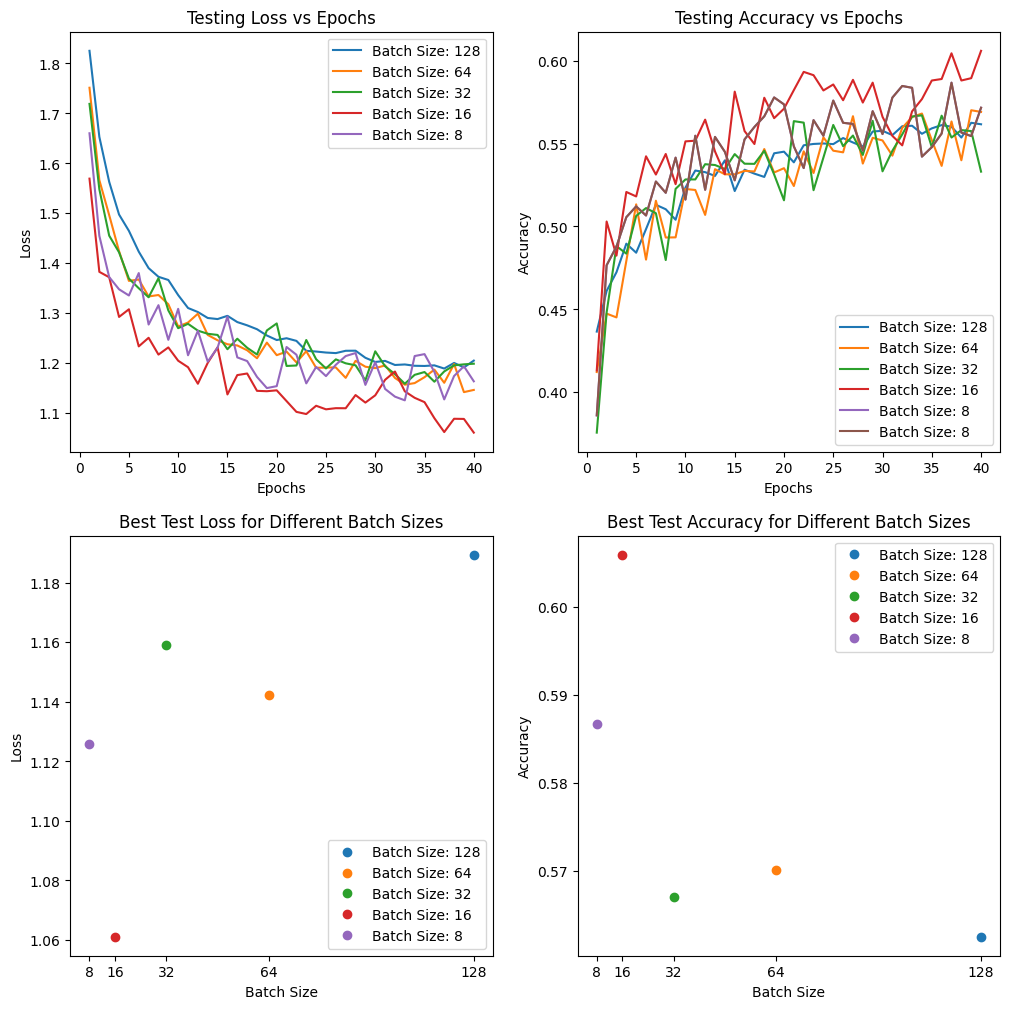

In [5]:
import matplotlib.pyplot as plt

# List of batch sizes
batch_sizes = [128, 64, 32, 16, 8]

# Plot test loss vs epoch for each batch size
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for batch_size in batch_sizes:
    # tr_loss = batch_tr_info[batch_size]["loss"]
    te_loss = batch_te_info[batch_size]["loss"]
    # axes[0, 0].plot(range(1, NUM_OF_EPOCHS + 1), tr_loss, label=f'Training Loss (Batch Size {batch_size})')
    axes[0, 0].plot(range(1, NUM_OF_EPOCHS + 1), te_loss, label=f'Batch Size: {batch_size}')
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Testing Loss vs Epochs')
axes[0, 0].legend()

# Plot test acc vs epoch for each batch size
for batch_size in batch_sizes:
    # tr_acc = batch_tr_info[batch_size]["acc"]
    te_acc = batch_te_info[batch_size]["acc"]
    # axes[0, 1].plot(range(1, NUM_OF_EPOCHS + 1), tr_loss, label=f'Training Acc (Batch Size {batch_size})')
    axes[0, 1].plot(range(1, NUM_OF_EPOCHS + 1), te_acc, label=f'Batch Size: {batch_size}')
axes[0, 1].plot(range(1, NUM_OF_EPOCHS + 1), te_acc, label=f'Batch Size: {batch_size}')
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_title('Testing Accuracy vs Epochs')
axes[0, 1].legend()

# Third subplot: Best Test Loss
for batch_size in batch_sizes:
    best_test_loss = min(batch_te_info[batch_size]['loss'])
    axes[1, 0].plot(batch_size, best_test_loss, 'o', label=f'Batch Size: {batch_size}')
axes[1, 0].set_xlabel('Batch Size');
axes[1, 0].set_xticks(batch_sizes)
axes[1, 0].set_ylabel('Loss')
axes[1, 0].set_title('Best Test Loss for Different Batch Sizes')
axes[1, 0].legend()

# Fourth subplot: Best Test Accuracy
for batch_size in batch_sizes:
    best_test_loss = max(batch_te_info[batch_size]["acc"])
    axes[1, 1].plot(batch_size, best_test_loss, 'o', label=f'Batch Size: {batch_size}')
axes[1, 1].set_xlabel('Batch Size');
axes[1, 1].set_xticks(batch_sizes)
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].set_title('Best Test Accuracy for Different Batch Sizes')
axes[1, 1].legend()
plt.show()

# accidentally re-run it, had to import saved img
# from matplotlib.image import imread
# # Define the file path
# file_path = 'training_information/mobile_v3_small/batch_loss_test_only_comparison_result.png'
#
# # Read and display the image
# img = imread(file_path)
# plt.figure(figsize=(12, 12))
# plt.imshow(img)
# plt.axis('off')  # Hide the axis
# plt.show()

Best test loss for each batch size with it's corresponding accuracy

In [6]:
for batch_size, info in batch_te_info.items():
    best_test_loss = 100
    best_epoch = 0
    for epoch, loss in enumerate(info["loss"]):
        if best_test_loss > loss:
            best_test_loss = loss
            best_epoch = epoch
    print(f"Batch size {batch_size}: Epoch {best_epoch} has {round(best_test_loss, 3)} loss with {round(info['acc'][best_epoch]*100, 2)}% accuracy")

Batch size 8: Epoch 32 has 1.126 loss with 58.36% accuracy
Batch size 16: Epoch 39 has 1.061 loss with 60.59% accuracy
Batch size 32: Epoch 32 has 1.159 loss with 56.63% accuracy
Batch size 64: Epoch 38 has 1.142 loss with 57.01% accuracy
Batch size 128: Epoch 36 has 1.189 loss with 56.01% accuracy


### Unfreeze all layers, batch 16

In [ ]:
m1 = torchvision.models.get_model("mobilenet_v3_small", num_classes=10, num_channels=1)

optimizer = torch.optim.Adam(m1.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

trainset = datasets.FashionMNIST('data/', download=True, train=True, transform=transform)
testset = datasets.FashionMNIST('data/', download=True, train=False, transform=transform)

In [18]:
batch_sizes = [16]

from training_and_evaluate import train_and_eval

batch_tr_info, batch_te_info = train_and_eval(model=m1, trainset=trainset, testset=testset, batch_sizes=batch_sizes,
                                              NAME_OF_MODEL=NAME_OF_MODEL, folder_to_save_in="unfreeze_all_layer",
                                              NUM_OF_EPOCHS=NUM_OF_EPOCHS,
                                              early_stopping_patience=EARLY_STOPPING_PATIENCE, NUM_OF_WORKERS=NUM_OF_WORKERS)

Epoch 1 Training...


100%|██████████| 3750/3750 [02:08<00:00, 29.18it/s]


Epoch 1 Testing...


100%|██████████| 625/625 [00:16<00:00, 37.31it/s]


Epoch 1: Train_accuracy: 81.19%, Train_loss: 0.513521, Test_accuracy: 87.89%, Test_loss: 0.350901
Epoch 2 Training...


100%|██████████| 3750/3750 [02:25<00:00, 25.79it/s]


Epoch 2 Testing...


100%|██████████| 625/625 [00:14<00:00, 42.95it/s]


Epoch 2: Train_accuracy: 88.91%, Train_loss: 0.311014, Test_accuracy: 87.91%, Test_loss: 0.335511
Epoch 3 Training...


100%|██████████| 3750/3750 [02:27<00:00, 25.43it/s]


Epoch 3 Testing...


100%|██████████| 625/625 [00:14<00:00, 44.01it/s]


Epoch 3: Train_accuracy: 90.79%, Train_loss: 0.262108, Test_accuracy: 90.92%, Test_loss: 0.252347
Epoch 4 Training...


100%|██████████| 3750/3750 [02:26<00:00, 25.53it/s]


Epoch 4 Testing...


100%|██████████| 625/625 [00:13<00:00, 45.97it/s]


Epoch 4: Train_accuracy: 91.59%, Train_loss: 0.233889, Test_accuracy: 90.86%, Test_loss: 0.257706
Epoch 5 Training...


100%|██████████| 3750/3750 [02:24<00:00, 25.91it/s]


Epoch 5 Testing...


100%|██████████| 625/625 [00:13<00:00, 46.24it/s]


Epoch 5: Train_accuracy: 92.37%, Train_loss: 0.211811, Test_accuracy: 91.25%, Test_loss: 0.245926
Epoch 6 Training...


100%|██████████| 3750/3750 [02:28<00:00, 25.25it/s]


Epoch 6 Testing...


100%|██████████| 625/625 [00:13<00:00, 46.76it/s]


Epoch 6: Train_accuracy: 93.05%, Train_loss: 0.192836, Test_accuracy: 92.33%, Test_loss: 0.216872
Epoch 7 Training...


100%|██████████| 3750/3750 [02:23<00:00, 26.12it/s]


Epoch 7 Testing...


100%|██████████| 625/625 [00:13<00:00, 44.76it/s]


Epoch 7: Train_accuracy: 93.60%, Train_loss: 0.177392, Test_accuracy: 92.30%, Test_loss: 0.226201
Epoch 8 Training...


100%|██████████| 3750/3750 [02:32<00:00, 24.52it/s]


Epoch 8 Testing...


100%|██████████| 625/625 [00:14<00:00, 43.59it/s]


Epoch 8: Train_accuracy: 93.99%, Train_loss: 0.164784, Test_accuracy: 92.90%, Test_loss: 0.202343
Epoch 9 Training...


100%|██████████| 3750/3750 [02:17<00:00, 27.31it/s]


Epoch 9 Testing...


100%|██████████| 625/625 [00:11<00:00, 53.80it/s]


Epoch 9: Train_accuracy: 94.62%, Train_loss: 0.151356, Test_accuracy: 92.89%, Test_loss: 0.213017
Epoch 10 Training...


100%|██████████| 3750/3750 [02:09<00:00, 28.86it/s]


Epoch 10 Testing...


100%|██████████| 625/625 [00:10<00:00, 56.83it/s]


Epoch 10: Train_accuracy: 95.05%, Train_loss: 0.136977, Test_accuracy: 92.64%, Test_loss: 0.228394
Epoch 11 Training...


100%|██████████| 3750/3750 [02:09<00:00, 28.86it/s]


Epoch 11 Testing...


100%|██████████| 625/625 [00:11<00:00, 55.10it/s]


Epoch 11: Train_accuracy: 95.44%, Train_loss: 0.127532, Test_accuracy: 92.09%, Test_loss: 0.246655
Epoch 12 Training...


100%|██████████| 3750/3750 [02:10<00:00, 28.82it/s]


Epoch 12 Testing...


100%|██████████| 625/625 [00:11<00:00, 56.28it/s]


Epoch 12: Train_accuracy: 95.78%, Train_loss: 0.117477, Test_accuracy: 93.27%, Test_loss: 0.217052
Epoch 13 Training...


100%|██████████| 3750/3750 [02:10<00:00, 28.78it/s]


Epoch 13 Testing...


100%|██████████| 625/625 [00:11<00:00, 56.07it/s]


Epoch 13: Train_accuracy: 96.05%, Train_loss: 0.110096, Test_accuracy: 92.78%, Test_loss: 0.226594
Epoch 14 Training...


100%|██████████| 3750/3750 [02:10<00:00, 28.78it/s]


Epoch 14 Testing...


100%|██████████| 625/625 [00:11<00:00, 56.46it/s]


Epoch 14: Train_accuracy: 96.41%, Train_loss: 0.099182, Test_accuracy: 93.09%, Test_loss: 0.241634
Epoch 15 Training...


100%|██████████| 3750/3750 [02:10<00:00, 28.83it/s]


Epoch 15 Testing...


100%|██████████| 625/625 [00:11<00:00, 56.57it/s]


Epoch 15: Train_accuracy: 96.58%, Train_loss: 0.093128, Test_accuracy: 93.20%, Test_loss: 0.232019
Epoch 16 Training...


100%|██████████| 3750/3750 [02:10<00:00, 28.67it/s]


Epoch 16 Testing...


100%|██████████| 625/625 [00:11<00:00, 52.88it/s]


Epoch 16: Train_accuracy: 96.96%, Train_loss: 0.085168, Test_accuracy: 92.94%, Test_loss: 0.237201
Epoch 17 Training...


100%|██████████| 3750/3750 [02:09<00:00, 28.86it/s]


Epoch 17 Testing...


100%|██████████| 625/625 [00:11<00:00, 56.19it/s]


Epoch 17: Train_accuracy: 97.17%, Train_loss: 0.079178, Test_accuracy: 93.03%, Test_loss: 0.254630
Epoch 18 Training...


100%|██████████| 3750/3750 [02:10<00:00, 28.77it/s]


Epoch 18 Testing...


100%|██████████| 625/625 [00:11<00:00, 55.38it/s]


Epoch 18: Train_accuracy: 97.27%, Train_loss: 0.074683, Test_accuracy: 93.12%, Test_loss: 0.257051
Epoch 19 Training...


100%|██████████| 3750/3750 [02:10<00:00, 28.64it/s]


Epoch 19 Testing...


100%|██████████| 625/625 [00:11<00:00, 55.55it/s]


Epoch 19: Train_accuracy: 97.50%, Train_loss: 0.068952, Test_accuracy: 92.92%, Test_loss: 0.267951
Epoch 20 Training...


100%|██████████| 3750/3750 [02:11<00:00, 28.46it/s]


Epoch 20 Testing...


100%|██████████| 625/625 [00:11<00:00, 54.23it/s]


Epoch 20: Train_accuracy: 97.63%, Train_loss: 0.065854, Test_accuracy: 93.18%, Test_loss: 0.261934
Epoch 21 Training...


100%|██████████| 3750/3750 [02:11<00:00, 28.56it/s]


Epoch 21 Testing...


100%|██████████| 625/625 [00:11<00:00, 53.84it/s]


Epoch 21: Train_accuracy: 97.74%, Train_loss: 0.063089, Test_accuracy: 92.77%, Test_loss: 0.295222
Epoch 22 Training...


100%|██████████| 3750/3750 [02:11<00:00, 28.54it/s]


Epoch 22 Testing...


100%|██████████| 625/625 [00:11<00:00, 55.29it/s]


Epoch 22: Train_accuracy: 97.89%, Train_loss: 0.058023, Test_accuracy: 93.28%, Test_loss: 0.256621
Epoch 23 Training...


100%|██████████| 3750/3750 [02:14<00:00, 27.88it/s]


Epoch 23 Testing...


100%|██████████| 625/625 [00:11<00:00, 54.35it/s]


Epoch 23: Train_accuracy: 98.13%, Train_loss: 0.054426, Test_accuracy: 93.27%, Test_loss: 0.280899
Epoch 24 Training...


100%|██████████| 3750/3750 [02:10<00:00, 28.77it/s]


Epoch 24 Testing...


100%|██████████| 625/625 [00:11<00:00, 55.45it/s]


Epoch 24: Train_accuracy: 98.10%, Train_loss: 0.051892, Test_accuracy: 93.24%, Test_loss: 0.290914
Epoch 25 Training...


100%|██████████| 3750/3750 [02:10<00:00, 28.63it/s]


Epoch 25 Testing...


100%|██████████| 625/625 [00:11<00:00, 56.02it/s]


Epoch 25: Train_accuracy: 98.20%, Train_loss: 0.051037, Test_accuracy: 92.69%, Test_loss: 0.309367
Epoch 26 Training...


100%|██████████| 3750/3750 [02:11<00:00, 28.52it/s]


Epoch 26 Testing...


100%|██████████| 625/625 [00:11<00:00, 55.49it/s]


Epoch 26: Train_accuracy: 98.30%, Train_loss: 0.048370, Test_accuracy: 93.44%, Test_loss: 0.282406
Epoch 27 Training...


100%|██████████| 3750/3750 [02:10<00:00, 28.80it/s]


Epoch 27 Testing...


100%|██████████| 625/625 [00:11<00:00, 55.20it/s]


Epoch 27: Train_accuracy: 98.32%, Train_loss: 0.046967, Test_accuracy: 93.07%, Test_loss: 0.307679
Epoch 28 Training...


100%|██████████| 3750/3750 [02:11<00:00, 28.60it/s]


Epoch 28 Testing...


100%|██████████| 625/625 [00:11<00:00, 55.63it/s]


Epoch 28: Train_accuracy: 98.49%, Train_loss: 0.043010, Test_accuracy: 92.93%, Test_loss: 0.315245
Epoch 29 Training...


100%|██████████| 3750/3750 [02:09<00:00, 28.91it/s]


Epoch 29 Testing...


100%|██████████| 625/625 [00:11<00:00, 54.99it/s]


Epoch 29: Train_accuracy: 98.52%, Train_loss: 0.043360, Test_accuracy: 93.14%, Test_loss: 0.313728
Epoch 30 Training...


100%|██████████| 3750/3750 [02:10<00:00, 28.82it/s]


Epoch 30 Testing...


100%|██████████| 625/625 [00:11<00:00, 53.80it/s]


Epoch 30: Train_accuracy: 98.56%, Train_loss: 0.040941, Test_accuracy: 93.23%, Test_loss: 0.315072
Epoch 31 Training...


100%|██████████| 3750/3750 [02:10<00:00, 28.68it/s]


Epoch 31 Testing...


100%|██████████| 625/625 [00:11<00:00, 55.72it/s]


Epoch 31: Train_accuracy: 98.68%, Train_loss: 0.039186, Test_accuracy: 93.30%, Test_loss: 0.324911
Epoch 32 Training...


100%|██████████| 3750/3750 [02:11<00:00, 28.52it/s]


Epoch 32 Testing...


100%|██████████| 625/625 [00:11<00:00, 54.44it/s]


Epoch 32: Train_accuracy: 98.63%, Train_loss: 0.038702, Test_accuracy: 93.23%, Test_loss: 0.315010
Epoch 33 Training...


100%|██████████| 3750/3750 [02:10<00:00, 28.73it/s]


Epoch 33 Testing...


100%|██████████| 625/625 [00:11<00:00, 54.39it/s]


Epoch 33: Train_accuracy: 98.78%, Train_loss: 0.036307, Test_accuracy: 93.61%, Test_loss: 0.318006
Epoch 34 Training...


100%|██████████| 3750/3750 [02:09<00:00, 29.05it/s]


Epoch 34 Testing...


100%|██████████| 625/625 [00:11<00:00, 56.18it/s]


Epoch 34: Train_accuracy: 98.66%, Train_loss: 0.037466, Test_accuracy: 93.63%, Test_loss: 0.295735
Epoch 35 Training...


100%|██████████| 3750/3750 [02:10<00:00, 28.72it/s]


Epoch 35 Testing...


100%|██████████| 625/625 [00:11<00:00, 54.71it/s]


Epoch 35: Train_accuracy: 98.74%, Train_loss: 0.035498, Test_accuracy: 92.92%, Test_loss: 0.340507
Epoch 36 Training...


100%|██████████| 3750/3750 [02:10<00:00, 28.63it/s]


Epoch 36 Testing...


100%|██████████| 625/625 [00:12<00:00, 51.96it/s]


Epoch 36: Train_accuracy: 98.79%, Train_loss: 0.034729, Test_accuracy: 93.18%, Test_loss: 0.352542
Epoch 37 Training...


100%|██████████| 3750/3750 [02:10<00:00, 28.74it/s]


Epoch 37 Testing...


100%|██████████| 625/625 [00:13<00:00, 45.51it/s]


Epoch 37: Train_accuracy: 98.86%, Train_loss: 0.033223, Test_accuracy: 93.19%, Test_loss: 0.337364
Epoch 38 Training...


100%|██████████| 3750/3750 [02:09<00:00, 28.95it/s]


Epoch 38 Testing...


100%|██████████| 625/625 [00:11<00:00, 56.24it/s]


Epoch 38: Train_accuracy: 98.89%, Train_loss: 0.032867, Test_accuracy: 93.05%, Test_loss: 0.345144
Epoch 39 Training...


100%|██████████| 3750/3750 [02:10<00:00, 28.83it/s]


Epoch 39 Testing...


100%|██████████| 625/625 [00:11<00:00, 55.73it/s]


Epoch 39: Train_accuracy: 98.89%, Train_loss: 0.031147, Test_accuracy: 92.92%, Test_loss: 0.377676
Epoch 40 Training...


100%|██████████| 3750/3750 [02:09<00:00, 29.06it/s]


Epoch 40 Testing...


100%|██████████| 625/625 [00:11<00:00, 55.62it/s]


Epoch 40: Train_accuracy: 98.98%, Train_loss: 0.030650, Test_accuracy: 93.39%, Test_loss: 0.345963
Epoch 41 Training...


100%|██████████| 3750/3750 [02:10<00:00, 28.78it/s]


Epoch 41 Testing...


100%|██████████| 625/625 [00:11<00:00, 55.65it/s]


Epoch 41: Train_accuracy: 98.97%, Train_loss: 0.029666, Test_accuracy: 93.12%, Test_loss: 0.348901
Epoch 42 Training...


100%|██████████| 3750/3750 [02:10<00:00, 28.81it/s]


Epoch 42 Testing...


100%|██████████| 625/625 [00:11<00:00, 56.04it/s]


Epoch 42: Train_accuracy: 98.95%, Train_loss: 0.030948, Test_accuracy: 93.30%, Test_loss: 0.345791
Epoch 43 Training...


100%|██████████| 3750/3750 [02:12<00:00, 28.22it/s]


Epoch 43 Testing...


100%|██████████| 625/625 [00:11<00:00, 55.62it/s]


Epoch 43: Train_accuracy: 99.04%, Train_loss: 0.026826, Test_accuracy: 93.22%, Test_loss: 0.393086
Epoch 44 Training...


100%|██████████| 3750/3750 [02:10<00:00, 28.66it/s]


Epoch 44 Testing...


100%|██████████| 625/625 [00:11<00:00, 54.82it/s]


Epoch 44: Train_accuracy: 98.92%, Train_loss: 0.029896, Test_accuracy: 93.44%, Test_loss: 0.346198
Epoch 45 Training...


100%|██████████| 3750/3750 [02:10<00:00, 28.82it/s]


Epoch 45 Testing...


100%|██████████| 625/625 [00:11<00:00, 55.57it/s]


Epoch 45: Train_accuracy: 99.02%, Train_loss: 0.028693, Test_accuracy: 92.80%, Test_loss: 0.354270
Epoch 46 Training...


100%|██████████| 3750/3750 [02:10<00:00, 28.70it/s]


Epoch 46 Testing...


100%|██████████| 625/625 [00:11<00:00, 55.16it/s]


Epoch 46: Train_accuracy: 99.09%, Train_loss: 0.026618, Test_accuracy: 92.98%, Test_loss: 0.357080
Epoch 47 Training...


100%|██████████| 3750/3750 [02:10<00:00, 28.65it/s]


Epoch 47 Testing...


100%|██████████| 625/625 [00:11<00:00, 56.81it/s]


Epoch 47: Train_accuracy: 99.05%, Train_loss: 0.027267, Test_accuracy: 93.51%, Test_loss: 0.357896
Epoch 48 Training...


100%|██████████| 3750/3750 [02:10<00:00, 28.74it/s]


Epoch 48 Testing...


100%|██████████| 625/625 [00:11<00:00, 56.37it/s]

Epoch 48: Train_accuracy: 99.09%, Train_loss: 0.026881, Test_accuracy: 92.98%, Test_loss: 0.364862
Early stopping triggered. No improvement for 40 epochs.


## Plot information

Import saved information

In [7]:
file_path = 'training_information/mobile_v3_small/unfreeze_all_layer/batch_te_info.pkl'
with open(file_path, 'rb') as file:
    batch_te_info = pickle.load(file)
file_path = 'training_information/mobile_v3_small/unfreeze_all_layer/batch_tr_info.pkl'
with open(file_path, 'rb') as file:
    batch_tr_info = pickle.load(file)

Plot information

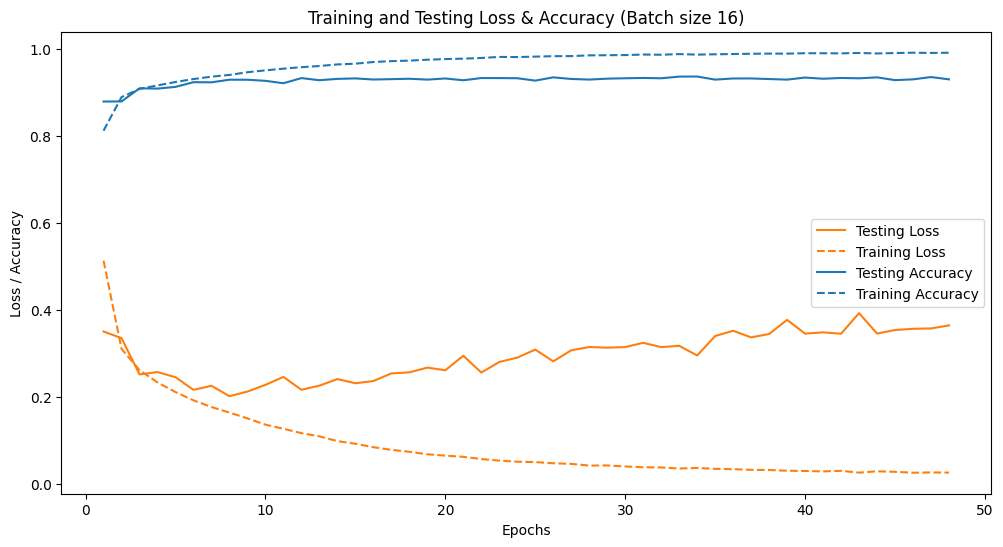

In [3]:
import matplotlib.pyplot as plt
# Specify the batch size you want to display
batch_size_to_display = 16

# Get the data for the specified batch size
te_loss = batch_te_info[batch_size_to_display]["loss"]
te_acc = batch_te_info[batch_size_to_display]["acc"]
tr_loss = batch_tr_info[batch_size_to_display]["loss"]
tr_acc = batch_tr_info[batch_size_to_display]["acc"]

# Create a single plot with combined training and testing information
plt.figure(figsize=(12, 6))

orange = 'tab:orange'  # Shades of orange
blue = 'tab:blue'  # An opposing color to orange

# Plot testing loss (shades of orange)
plt.plot(range(1, len(te_loss) + 1), te_loss, label=f'Testing Loss', color=orange)

# Plot training loss (shades of orange, different linestyle)
plt.plot(range(1, len(te_loss) + 1), tr_loss, label=f'Training Loss', linestyle='--', color=orange)

# Plot testing accuracy (shades of an opposing color)
plt.plot(range(1, len(te_loss) + 1), te_acc, label=f'Testing Accuracy', color=blue)

# Plot training accuracy (shades of an opposing color, different linestyle)
plt.plot(range(1, len(te_loss) + 1), tr_acc, label=f'Training Accuracy', linestyle='--', color=blue)

plt.xlabel('Epochs')
plt.ylabel('Loss / Accuracy')
plt.title('Training and Testing Loss & Accuracy (Batch size 16)')
plt.legend()

plt.show()

Best test loss for each batch size with it's corresponding accuracy

In [4]:
for batch_size, info in batch_te_info.items():
    best_test_loss = 100
    best_epoch = 0
    for epoch, loss in enumerate(info["loss"]):
        if best_test_loss > loss:
            best_test_loss = loss
            best_epoch = epoch
    print(f"Batch size {batch_size}: Epoch {best_epoch} has {round(best_test_loss, 3)} loss with {round(info['acc'][best_epoch]*100, 2)}% accuracy")

Batch size 16: Epoch 7 has 0.202 loss with 92.9% accuracy


# Mixup

In [8]:
m1 = torchvision.models.get_model("mobilenet_v3_small", num_classes=10)

optimizer = torch.optim.Adam(m1.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

early_stopping_patience = 15
NUM_OF_EPOCHS = 100
BATCH_SIZE = 16

In [9]:
batch_sizes = [BATCH_SIZE]

from training_and_evaluate import train_and_eval

batch_tr_info, batch_te_info = train_and_eval(model=m1, trainset=trainset, testset=testset, batch_sizes=batch_sizes,
                                              NAME_OF_MODEL=NAME_OF_MODEL, folder_to_save_in="mixup",
                                              NUM_OF_EPOCHS=NUM_OF_EPOCHS,
                                              early_stopping_patience=EARLY_STOPPING_PATIENCE,
                                              NUM_OF_WORKERS=NUM_OF_WORKERS, mixup=True)

Device: cuda:0
Epoch 1 Training...


100%|██████████| 3750/3750 [04:44<00:00, 13.18it/s]


Epoch 1 Testing...


100%|██████████| 625/625 [00:19<00:00, 32.81it/s]


Epoch 1: Train_accuracy: 70.34%, Train_loss: 1.112900, Test_accuracy: 72.68%, Test_loss: 0.977658
Epoch 2 Training...


100%|██████████| 3750/3750 [04:37<00:00, 13.53it/s]


Epoch 2 Testing...


100%|██████████| 625/625 [00:22<00:00, 28.21it/s]


Epoch 2: Train_accuracy: 76.43%, Train_loss: 0.905968, Test_accuracy: 76.18%, Test_loss: 0.898681
Epoch 3 Training...


100%|██████████| 3750/3750 [04:29<00:00, 13.92it/s]


Epoch 3 Testing...


100%|██████████| 625/625 [00:20<00:00, 30.26it/s]


Epoch 3: Train_accuracy: 78.23%, Train_loss: 0.846578, Test_accuracy: 75.23%, Test_loss: 0.861263
Epoch 4 Training...


100%|██████████| 3750/3750 [04:41<00:00, 13.30it/s]


Epoch 4 Testing...


100%|██████████| 625/625 [00:20<00:00, 30.66it/s]


Epoch 4: Train_accuracy: 79.25%, Train_loss: 0.818194, Test_accuracy: 79.53%, Test_loss: 0.785691
Epoch 5 Training...


100%|██████████| 3750/3750 [04:46<00:00, 13.09it/s]


Epoch 5 Testing...


100%|██████████| 625/625 [00:26<00:00, 23.39it/s]


Epoch 5: Train_accuracy: 79.90%, Train_loss: 0.795009, Test_accuracy: 80.35%, Test_loss: 0.795465
Epoch 6 Training...


100%|██████████| 3750/3750 [04:48<00:00, 13.01it/s]


Epoch 6 Testing...


100%|██████████| 625/625 [00:25<00:00, 24.76it/s]


Epoch 6: Train_accuracy: 80.88%, Train_loss: 0.774373, Test_accuracy: 79.22%, Test_loss: 0.789520
Epoch 7 Training...


100%|██████████| 3750/3750 [04:49<00:00, 12.94it/s]


Epoch 7 Testing...


100%|██████████| 625/625 [00:18<00:00, 34.71it/s]


Epoch 7: Train_accuracy: 81.36%, Train_loss: 0.758687, Test_accuracy: 81.55%, Test_loss: 0.777819
Epoch 8 Training...


100%|██████████| 3750/3750 [04:38<00:00, 13.47it/s]


Epoch 8 Testing...


100%|██████████| 625/625 [00:20<00:00, 30.11it/s]


Epoch 8: Train_accuracy: 81.46%, Train_loss: 0.749032, Test_accuracy: 81.89%, Test_loss: 0.758132
Epoch 9 Training...


100%|██████████| 3750/3750 [04:49<00:00, 12.94it/s]


Epoch 9 Testing...


100%|██████████| 625/625 [00:20<00:00, 31.12it/s]


Epoch 9: Train_accuracy: 82.41%, Train_loss: 0.732105, Test_accuracy: 82.74%, Test_loss: 0.729467
Epoch 10 Training...


100%|██████████| 3750/3750 [04:42<00:00, 13.26it/s]


Epoch 10 Testing...


100%|██████████| 625/625 [00:18<00:00, 33.48it/s]


Epoch 10: Train_accuracy: 82.67%, Train_loss: 0.726506, Test_accuracy: 83.02%, Test_loss: 0.755372
Epoch 11 Training...


100%|██████████| 3750/3750 [04:47<00:00, 13.06it/s]


Epoch 11 Testing...


100%|██████████| 625/625 [00:20<00:00, 30.67it/s]


Epoch 11: Train_accuracy: 83.13%, Train_loss: 0.715874, Test_accuracy: 82.68%, Test_loss: 0.727599
Epoch 12 Training...


100%|██████████| 3750/3750 [04:48<00:00, 13.02it/s]


Epoch 12 Testing...


100%|██████████| 625/625 [00:20<00:00, 30.75it/s]


Epoch 12: Train_accuracy: 83.41%, Train_loss: 0.714500, Test_accuracy: 83.35%, Test_loss: 0.758987
Epoch 13 Training...


100%|██████████| 3750/3750 [04:34<00:00, 13.68it/s]


Epoch 13 Testing...


100%|██████████| 625/625 [00:20<00:00, 31.10it/s]


Epoch 13: Train_accuracy: 83.47%, Train_loss: 0.707633, Test_accuracy: 82.07%, Test_loss: 0.750008
Epoch 14 Training...


100%|██████████| 3750/3750 [04:48<00:00, 12.99it/s]


Epoch 14 Testing...


100%|██████████| 625/625 [00:20<00:00, 31.18it/s]


Epoch 14: Train_accuracy: 83.57%, Train_loss: 0.700335, Test_accuracy: 83.54%, Test_loss: 0.738942
Epoch 15 Training...


100%|██████████| 3750/3750 [04:47<00:00, 13.05it/s]


Epoch 15 Testing...


100%|██████████| 625/625 [00:19<00:00, 32.27it/s]


Epoch 15: Train_accuracy: 84.33%, Train_loss: 0.692188, Test_accuracy: 84.28%, Test_loss: 0.717202
Epoch 16 Training...


100%|██████████| 3750/3750 [04:50<00:00, 12.91it/s]


Epoch 16 Testing...


100%|██████████| 625/625 [00:18<00:00, 33.22it/s]


Epoch 16: Train_accuracy: 84.02%, Train_loss: 0.691080, Test_accuracy: 83.02%, Test_loss: 0.717197
Epoch 17 Training...


100%|██████████| 3750/3750 [04:48<00:00, 13.01it/s]


Epoch 17 Testing...


100%|██████████| 625/625 [00:18<00:00, 32.95it/s]


Epoch 17: Train_accuracy: 84.45%, Train_loss: 0.685412, Test_accuracy: 84.42%, Test_loss: 0.723740
Epoch 18 Training...


100%|██████████| 3750/3750 [04:37<00:00, 13.53it/s]


Epoch 18 Testing...


100%|██████████| 625/625 [00:18<00:00, 33.06it/s]


Epoch 18: Train_accuracy: 84.43%, Train_loss: 0.683024, Test_accuracy: 83.80%, Test_loss: 0.717416
Epoch 19 Training...


100%|██████████| 3750/3750 [04:50<00:00, 12.92it/s]


Epoch 19 Testing...


100%|██████████| 625/625 [00:18<00:00, 33.47it/s]


Epoch 19: Train_accuracy: 84.53%, Train_loss: 0.682690, Test_accuracy: 85.66%, Test_loss: 0.696847
Epoch 20 Training...


100%|██████████| 3750/3750 [04:49<00:00, 12.96it/s]


Epoch 20 Testing...


100%|██████████| 625/625 [00:20<00:00, 31.03it/s]


Epoch 20: Train_accuracy: 85.42%, Train_loss: 0.667717, Test_accuracy: 84.45%, Test_loss: 0.701416
Epoch 21 Training...


100%|██████████| 3750/3750 [04:43<00:00, 13.24it/s]


Epoch 21 Testing...


100%|██████████| 625/625 [00:18<00:00, 33.35it/s]


Epoch 21: Train_accuracy: 85.00%, Train_loss: 0.669467, Test_accuracy: 84.64%, Test_loss: 0.704457
Epoch 22 Training...


100%|██████████| 3750/3750 [04:48<00:00, 13.01it/s]


Epoch 22 Testing...


100%|██████████| 625/625 [00:18<00:00, 33.21it/s]


Epoch 22: Train_accuracy: 85.43%, Train_loss: 0.669205, Test_accuracy: 82.83%, Test_loss: 0.748665
Epoch 23 Training...


100%|██████████| 3750/3750 [04:43<00:00, 13.23it/s]


Epoch 23 Testing...


100%|██████████| 625/625 [00:19<00:00, 31.35it/s]


Epoch 23: Train_accuracy: 85.50%, Train_loss: 0.660854, Test_accuracy: 84.79%, Test_loss: 0.718132
Epoch 24 Training...


100%|██████████| 3750/3750 [04:49<00:00, 12.95it/s]


Epoch 24 Testing...


100%|██████████| 625/625 [00:19<00:00, 31.73it/s]


Epoch 24: Train_accuracy: 85.69%, Train_loss: 0.658511, Test_accuracy: 83.94%, Test_loss: 0.723429
Epoch 25 Training...


100%|██████████| 3750/3750 [04:48<00:00, 13.01it/s]


Epoch 25 Testing...


100%|██████████| 625/625 [00:18<00:00, 33.05it/s]


Epoch 25: Train_accuracy: 85.88%, Train_loss: 0.654324, Test_accuracy: 83.62%, Test_loss: 0.723386
Epoch 26 Training...


100%|██████████| 3750/3750 [04:39<00:00, 13.43it/s]


Epoch 26 Testing...


100%|██████████| 625/625 [00:18<00:00, 33.50it/s]


Epoch 26: Train_accuracy: 86.28%, Train_loss: 0.650138, Test_accuracy: 84.95%, Test_loss: 0.734698
Epoch 27 Training...


100%|██████████| 3750/3750 [04:47<00:00, 13.06it/s]


Epoch 27 Testing...


100%|██████████| 625/625 [00:18<00:00, 33.36it/s]


Epoch 27: Train_accuracy: 86.33%, Train_loss: 0.650555, Test_accuracy: 85.05%, Test_loss: 0.697268
Epoch 28 Training...


100%|██████████| 3750/3750 [04:48<00:00, 12.99it/s]


Epoch 28 Testing...


100%|██████████| 625/625 [00:18<00:00, 33.48it/s]


Epoch 28: Train_accuracy: 86.16%, Train_loss: 0.647289, Test_accuracy: 84.07%, Test_loss: 0.732980
Epoch 29 Training...


100%|██████████| 3750/3750 [04:43<00:00, 13.22it/s]


Epoch 29 Testing...


100%|██████████| 625/625 [00:18<00:00, 33.86it/s]


Epoch 29: Train_accuracy: 86.32%, Train_loss: 0.644534, Test_accuracy: 84.77%, Test_loss: 0.712701
Epoch 30 Training...


100%|██████████| 3750/3750 [04:48<00:00, 12.99it/s]


Epoch 30 Testing...


100%|██████████| 625/625 [00:18<00:00, 33.19it/s]


Epoch 30: Train_accuracy: 86.19%, Train_loss: 0.646738, Test_accuracy: 85.26%, Test_loss: 0.711551
Epoch 31 Training...


100%|██████████| 3750/3750 [04:43<00:00, 13.23it/s]


Epoch 31 Testing...


100%|██████████| 625/625 [00:19<00:00, 32.67it/s]


Epoch 31: Train_accuracy: 86.62%, Train_loss: 0.639448, Test_accuracy: 85.17%, Test_loss: 0.711606
Epoch 32 Training...


100%|██████████| 3750/3750 [04:48<00:00, 13.02it/s]


Epoch 32 Testing...


100%|██████████| 625/625 [00:19<00:00, 32.87it/s]


Epoch 32: Train_accuracy: 86.22%, Train_loss: 0.642112, Test_accuracy: 83.65%, Test_loss: 0.733629
Epoch 33 Training...


100%|██████████| 3750/3750 [04:48<00:00, 12.99it/s]


Epoch 33 Testing...


100%|██████████| 625/625 [00:19<00:00, 32.73it/s]


Epoch 33: Train_accuracy: 86.64%, Train_loss: 0.635291, Test_accuracy: 85.76%, Test_loss: 0.704685
Epoch 34 Training...


100%|██████████| 3750/3750 [04:38<00:00, 13.46it/s]


Epoch 34 Testing...


100%|██████████| 625/625 [00:18<00:00, 32.93it/s]

Epoch 34: Train_accuracy: 86.74%, Train_loss: 0.633843, Test_accuracy: 85.67%, Test_loss: 0.719426
Early stopping triggered. No improvement for 15 epochs.


## Plot information

Import saved information

In [12]:
file_path = 'training_information/mobile_v3_small/mixup/batch_te_info.pkl'
with open(file_path, 'rb') as file:
    batch_te_info = pickle.load(file)
file_path = 'training_information/mobile_v3_small/mixup/batch_tr_info.pkl'
with open(file_path, 'rb') as file:
    batch_tr_info = pickle.load(file)

Plot information

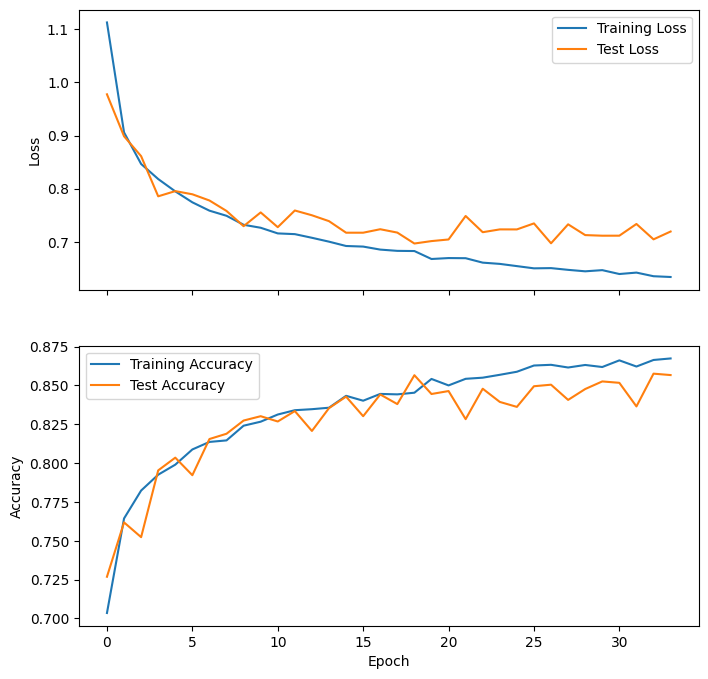

In [13]:
import matplotlib.pyplot as plt

# Create a figure with larger subplots
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 8))  # Adjust the figsize as needed

# Plot the training and test loss on the first subplot
ax1.plot(batch_tr_info[BATCH_SIZE]["loss"], label="Training Loss")
ax1.plot(batch_te_info[BATCH_SIZE]["loss"], label="Test Loss")
ax1.set_ylabel("Loss")
ax1.legend()

# Plot the training and test accuracy on the second subplot
ax2.plot(batch_tr_info[BATCH_SIZE]["acc"], label="Training Accuracy")
ax2.plot(batch_te_info[BATCH_SIZE]["acc"], label="Test Accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.legend()

# Show the plot
plt.show()

Best test loss for each batch size with it's corresponding accuracy

In [14]:
for batch_size, info in batch_te_info.items():
    best_test_loss = 100
    best_epoch = 0
    for epoch, loss in enumerate(info["loss"]):
        if best_test_loss > loss:
            best_test_loss = loss
            best_epoch = epoch
    print(f"Batch size {batch_size}: Epoch {best_epoch} has {round(best_test_loss, 3)} loss with {round(info['acc'][best_epoch]*100, 2)}% accuracy")

Batch size 16: Epoch 18 has 0.697 loss with 85.66% accuracy
